In [1]:
import numpy as np
from numpy import exp, loadtxt, pi, sqrt
from scipy import stats
from scipy.stats import binned_statistic 
from astropy.table import Table, Column, MaskedColumn
import math
import matplotlib.pyplot as plt
import pylab
from astropy.io import ascii
import pickle
import pandas as pd
import os.path
from numpy import exp, loadtxt, pi, sqrt
from scipy.stats import ks_2samp
import array
import matplotlib
import time
from matplotlib import ticker, cm

In [2]:
def am(val):
    return (val[1:]+val[:-1])/2

from scipy import interpolate
def confidence_intervals(z,dx=1,dy=1):
    """
    takes normalised probability distribution as input (fi dx,dy=1 then probdist=n/Ntotal)
    outputs the level of the contour at which 75% 50% and 25%
    """
    n = 20
    t = np.linspace(0, z.max(), n)
    integral = ((z >= t[:, None, None]) * z).sum(axis=(1,2)) *dx*dy
    f = interpolate.interp1d(integral, t)
    t_contours = f(np.array([0.95,0.68,0.40]))
    return np.append(t_contours,1)

In [3]:
def easyplot(valx,valy,valp,edgex,edgey,lrview=True,predview=True):
    alpha=0.26
    if lrview ==True:
        lvl = confidence_intervals(valx.T/valx.sum())
        ax.contourf(edgex,edgey,valx.T/valx.sum(),colors=colorp,levels=lvl,alpha=alpha)
        c1 = ax.contour(edgex,edgey,valx.T/valx.sum(),levels=lvl,colors=colorpp,linewidths=3)
        h1,l1 = c1.legend_elements()
    else:
        h1=None
    lvl = confidence_intervals(valy.T/valy.sum())
    ax.contourf(edgex,edgey,valy.T/valy.sum(),levels=lvl,colors=coloroo,alpha=alpha)
    c2 = ax.contour(edgex,edgey,valy.T/valy.sum(),levels=lvl,colors=coloro,linewidths=3)
    h2,l1 = c2.legend_elements()
    if predview == True:
        lvl = confidence_intervals(valp.T/valp.sum())
        CS = ax.contour(edgex,edgey,valp.T/valp.sum(),levels=lvl,colors=colorb,linewidths=4,linestyles='dashed')
        h3,l3 = CS.legend_elements()
        for c in CS.collections:
            c.set_dashes([(1,(3.0,3.0))])
    else:
        h3=None
    return h1,h2,h3

In [4]:
from haloscope import ConditionalMultiVariateGaussian 

In [5]:
font1 = {'color':  'red',
        'weight': 'normal',
        'size': 13,
        }
font2 = {'color':  'darkmagenta',
        'weight': 'normal',
        'size': 13,
        }
font3 = {'color':  'darkgreen',
        'weight': 'normal',
        'size': 13,
        }
font4 = {'color':  'black',
        'weight': 'normal',
        'size': 12.5,
        }

# READ data

## ASTRID

In [6]:
path = '../Data/Rockstar/Astrid/L25n256/CV/CV_'
pd.read_table(path + '0/hlists/hlist_1.00000.list', sep='\s+').columns

Index(['#scale(0)', 'id(1)', 'desc_scale(2)', 'desc_id(3)', 'num_prog(4)',
       'pid(5)', 'upid(6)', 'desc_pid(7)', 'phantom(8)', 'sam_Mvir(9)',
       'Mvir(10)', 'Rvir(11)', 'rs(12)', 'vrms(13)', 'mmp?(14)',
       'scale_of_last_MM(15)', 'vmax(16)', 'x(17)', 'y(18)', 'z(19)', 'vx(20)',
       'vy(21)', 'vz(22)', 'Jx(23)', 'Jy(24)', 'Jz(25)', 'Spin(26)',
       'Breadth_first_ID(27)', 'Depth_first_ID(28)', 'Tree_root_ID(29)',
       'Orig_halo_ID(30)', 'Snap_idx(31)',
       'Next_coprogenitor_depthfirst_ID(32)',
       'Last_progenitor_depthfirst_ID(33)', 'Last_mainleaf_depthfirst_ID(34)',
       'Tidal_Force(35)', 'Tidal_ID(36)', 'Rs_Klypin(37)', 'Mvir_all(38)',
       'M200b(39)', 'M200c(40)', 'M500c(41)', 'M2500c(42)', 'Xoff(43)',
       'Voff(44)', 'Spin_Bullock(45)', 'b_to_a(46)', 'c_to_a(47)', 'A[x](48)',
       'A[y](49)', 'A[z](50)', 'b_to_a(500c)(51)', 'c_to_a(500c)(52)',
       'A[x](500c)(53)', 'A[y](500c)(54)', 'A[z](500c)(55)', 'T/|U|(56)',
       'M_pe_Behroozi(57)',

In [7]:
nsim = 27
lista_columns = ['id','pid','Rvir','Spin','Rs_Klypin','M200b','ba','ca','ba500c','ca500c','T_U','Vpeak','TidalForce'] 

path = '../Data/Rockstar/Astrid/L25n256/CV/CV_'
for i in range(nsim):
    if (i == 0):
        Astrid_data_bar = pd.read_table(path + str(i) + '/hlists/hlist_1.00000.list', index_col=False, header=63, sep='\s+', names=lista_columns, 
                         usecols=(1,5,11,26,37,39,46,47,51,52,56,63,78), low_memory=False)
    if (i > 0) & (i != 8): 
        data_aux = pd.read_table(path + str(i) + '/hlists/hlist_1.00000.list', index_col=False, header=63, sep='\s+', names=lista_columns, 
                         usecols=(1,5,11,26,37,39,46,47,51,52,56,63,78), low_memory=False)
        Astrid_data_bar = pd.concat([Astrid_data_bar, data_aux])
  

cv = Astrid_data_bar.Rvir / Astrid_data_bar.Rs_Klypin
Astrid_data_bar.insert(9,'cv', cv)
Astrid_data_bar

,id,pid,Rvir,Spin,Rs_Klypin,M200b,ba,ca,ba500c,cv,ca500c,T_U,Vpeak,TidalForce
0,900126,-1,755.708,0.01619,100.88300,56390000000000,0.71603,0.44611,0.66172,7.490935,0.42536,0.5696,5.074000e+13,5.074000e+13
1,900240,-1,598.937,0.02747,123.80400,28280000000000,0.61954,0.50558,0.58238,4.837784,0.47910,0.5692,2.526000e+13,2.526000e+13
2,904251,-1,593.485,0.09882,117.86100,27431000000000,0.65766,0.48063,0.62263,5.035466,0.50743,0.6636,2.458000e+13,2.458000e+13
3,904212,-1,566.236,0.02464,70.29040,24817000000000,0.60690,0.51821,0.56894,8.055666,0.47420,0.5499,2.135000e+13,2.135000e+13
4,897494,-1,551.313,0.04683,63.93480,21587000000000,0.53750,0.45687,0.49806,8.623050,0.39415,0.6250,1.970000e+13,1.970000e+13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6997,925351,-1,10.334,0.00000,2.47929,129760000,0.00000,0.00000,0.00000,4.168129,0.00000,0.0000,1.298000e+08,1.298000e+08
6998,926645,-1,10.334,0.00000,2.36318,583930000,0.00000,0.00000,0.00000,4.372921,0.00000,0.0000,1.298000e+08,1.298000e+08
6999,931474,-1,10.334,0.00000,3.26225,259520000,0.00000,0.00000,0.00000,3.167752,0.00000,0.0000,1.298000e+08,1.298000e+08
7000,932881,-1,10.334,0.00000,1.17676,2775700000,0.00000,0.00000,0.00000,8.781740,0.00000,0.0000,1.298000e+08,1.298000e+08


In [8]:
path = '../Data/Rockstar/Astrid_DM/L25n256/CV/CV_'
pd.read_table(path + str(i) + '/hlists/hlist_1.00000.list', sep='\s+').columns

Index(['#scale(0)', 'id(1)', 'desc_scale(2)', 'desc_id(3)', 'num_prog(4)',
       'pid(5)', 'upid(6)', 'desc_pid(7)', 'phantom(8)', 'sam_Mvir(9)',
       'Mvir(10)', 'Rvir(11)', 'rs(12)', 'vrms(13)', 'mmp?(14)',
       'scale_of_last_MM(15)', 'vmax(16)', 'x(17)', 'y(18)', 'z(19)', 'vx(20)',
       'vy(21)', 'vz(22)', 'Jx(23)', 'Jy(24)', 'Jz(25)', 'Spin(26)',
       'Breadth_first_ID(27)', 'Depth_first_ID(28)', 'Tree_root_ID(29)',
       'Orig_halo_ID(30)', 'Snap_idx(31)',
       'Next_coprogenitor_depthfirst_ID(32)',
       'Last_progenitor_depthfirst_ID(33)', 'Last_mainleaf_depthfirst_ID(34)',
       'Tidal_Force(35)', 'Tidal_ID(36)', 'Rs_Klypin(37)', 'Mvir_all(38)',
       'M200b(39)', 'M200c(40)', 'M500c(41)', 'M2500c(42)', 'Xoff(43)',
       'Voff(44)', 'Spin_Bullock(45)', 'b_to_a(46)', 'c_to_a(47)', 'A[x](48)',
       'A[y](49)', 'A[z](50)', 'b_to_a(500c)(51)', 'c_to_a(500c)(52)',
       'A[x](500c)(53)', 'A[y](500c)(54)', 'A[z](500c)(55)', 'T/|U|(56)',
       'M_pe_Behroozi(57)',

In [9]:

for i in range(nsim):
    if i == 0:
        Astrid_data_dm = pd.read_table(path + str(i) + '/hlists/hlist_1.00000.list', index_col=False, header=64, sep='\s+', names=lista_columns, 
                         usecols=(1,5,11,26,37,39,46,47,51,52,56,63,78), low_memory=False)
    if i > 0 & (i != 8): 
        data_aux = pd.read_table(path + str(i) + '/hlists/hlist_1.00000.list', index_col=False, header=64, sep='\s+', names=lista_columns, 
                         usecols=(1,5,11,26,37,39,46,47,51,52,56,63,78), low_memory=False)
        Astrid_data_dm = pd.concat([Astrid_data_dm, data_aux])
  

cv = Astrid_data_dm.Rvir / Astrid_data_dm.Rs_Klypin
Astrid_data_dm.insert(9,'cv', cv)
M200b_02dex_log = 10.**(np.log10(Astrid_data_dm.M200b)-0.1)
Astrid_data_dm.insert(6,'M200b02d', M200b_02dex_log)
Astrid_data_dm

,id,pid,Rvir,Spin,Rs_Klypin,M200b,M200b02d,ba,ca,ba500c,cv,ca500c,T_U,Vpeak,TidalForce
0,691702,-1,753.639,0.01984,80.45650,54821000000000,4.354587e+13,0.69911,0.42585,0.65934,9.367037,0.42504,0.6107,684.72,0.00000
1,692384,-1,605.162,0.02465,89.79320,28508000000000,2.264471e+13,0.59885,0.48451,0.52785,6.739508,0.45574,0.6022,565.59,0.00000
2,695467,-1,599.448,0.09857,110.76000,27406000000000,2.176936e+13,0.66712,0.44796,0.53508,5.412134,0.49556,0.6834,499.16,0.18681
3,695630,-1,574.542,0.02356,55.40720,25311000000000,2.010524e+13,0.55621,0.48302,0.51992,10.369447,0.44616,0.5849,530.65,0.29555
4,689662,-1,568.311,0.04274,51.51310,22619000000000,1.796691e+13,0.52233,0.50317,0.49328,11.032359,0.47158,0.6427,508.21,0.08503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7372,711332,708734,18.753,0.11381,0.52776,853010000,6.775699e+08,0.09691,0.02603,0.06397,35.533197,0.02806,1.3572,36.26,1.43652
7373,710703,-1,18.106,0.14556,6.32030,1318300000,1.047163e+09,0.26049,0.06952,0.00000,2.864737,0.00000,2.0908,40.68,1.32153
7374,708690,-1,17.409,0.46150,2.61968,853010000,6.775699e+08,0.84240,0.21756,0.00000,6.645468,0.00000,3.6688,44.16,1.37566
7375,708587,-1,15.817,0.35304,1.12415,1473400000,1.170363e+09,0.08329,0.00000,0.00000,14.070186,0.00000,3.8235,26.64,1.32214


## TNG

In [10]:
path = '../Data/Rockstar/IllustrisTNG/L25n256/CV/CV_'
pd.read_table(path + str(i) + '/hlists/hlist_1.00000.list', sep='\s+').columns

Index(['#scale(0)', 'id(1)', 'desc_scale(2)', 'desc_id(3)', 'num_prog(4)',
       'pid(5)', 'upid(6)', 'desc_pid(7)', 'phantom(8)', 'sam_Mvir(9)',
       'Mvir(10)', 'Rvir(11)', 'rs(12)', 'vrms(13)', 'mmp?(14)',
       'scale_of_last_MM(15)', 'vmax(16)', 'x(17)', 'y(18)', 'z(19)', 'vx(20)',
       'vy(21)', 'vz(22)', 'Jx(23)', 'Jy(24)', 'Jz(25)', 'Spin(26)',
       'Breadth_first_ID(27)', 'Depth_first_ID(28)', 'Tree_root_ID(29)',
       'Orig_halo_ID(30)', 'Snap_idx(31)',
       'Next_coprogenitor_depthfirst_ID(32)',
       'Last_progenitor_depthfirst_ID(33)', 'Last_mainleaf_depthfirst_ID(34)',
       'Tidal_Force(35)', 'Tidal_ID(36)', 'Rs_Klypin(37)', 'Mvir_all(38)',
       'M200b(39)', 'M200c(40)', 'M500c(41)', 'M2500c(42)', 'Xoff(43)',
       'Voff(44)', 'Spin_Bullock(45)', 'b_to_a(46)', 'c_to_a(47)', 'A[x](48)',
       'A[y](49)', 'A[z](50)', 'b_to_a(500c)(51)', 'c_to_a(500c)(52)',
       'A[x](500c)(53)', 'A[y](500c)(54)', 'A[z](500c)(55)', 'T/|U|(56)',
       'M_pe_Behroozi(57)',

In [11]:
nsim = 27
lista_columns = ['id','pid','Rvir','Spin','Rs_Klypin','M200b','ba','ca','ba500c','ca500c','T_U','Vpeak','TidalForce'] 

path = '../Data/Rockstar/IllustrisTNG/L25n256/CV/CV_'

for i in range(nsim):
    if i == 0:
        Illustris_data_bar = pd.read_table(path + str(i) + '/hlists/hlist_1.00000.list', index_col=False, header=63, sep='\s+', names=lista_columns, 
                         usecols=(1,5,11,26,37,39,46,47,51,52,56,66,81), low_memory=False)
    if i > 0: 
        data_aux = pd.read_table(path + str(i) + '/hlists/hlist_1.00000.list', index_col=False, header=63, sep='\s+', names=lista_columns, 
                         usecols=(1,5,11,26,37,39,46,47,51,52,56,66,81), low_memory=False)
        Illustris_data_bar = pd.concat([Illustris_data_bar, data_aux])
  

cv = Illustris_data_bar.Rvir / Illustris_data_bar.Rs_Klypin
Illustris_data_bar.insert(9,'cv', cv)
Illustris_data_bar

,id,pid,Rvir,Spin,Rs_Klypin,M200b,ba,ca,ba500c,cv,ca500c,T_U,Vpeak,TidalForce
0,344582,-1,761.179,0.01576,108.21300,57599000000000,0.70149,0.44993,0.66518,7.034081,0.43560,0.5670,661.41,0.00000
1,344705,-1,592.586,0.02655,117.58700,27568000000000,0.85064,0.63682,0.73052,5.039554,0.55627,0.5810,503.76,0.00000
2,348606,-1,589.585,0.09712,117.70500,26475000000000,0.56102,0.39976,0.49704,5.009006,0.40053,0.6748,445.41,0.07410
3,348588,-1,553.399,0.02610,69.91930,23552000000000,0.60733,0.51191,0.58078,7.914825,0.47700,0.5717,488.02,0.39902
4,343262,-1,550.248,0.01791,37.00850,22924000000000,0.71073,0.66767,0.71648,14.868152,0.66056,0.5459,540.42,0.01230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6857,359728,-1,11.830,0.02716,0.64873,3828000000,0.00000,0.00000,0.00000,18.235630,0.00000,0.3845,11.79,0.34484
6858,359426,-1,10.666,0.66985,0.69526,10951000000,0.00000,0.00000,0.00000,15.341024,0.00000,5.0693,10.14,0.20836
6859,355962,-1,10.334,0.00000,0.74380,202260000,0.00000,0.00000,0.00000,13.893520,0.00000,0.0000,9.58,0.20881
6860,356573,-1,10.334,0.00000,3.38284,259520000,0.00000,0.00000,0.00000,3.054830,0.00000,0.0000,7.46,0.25238


In [12]:
path = '../Data/Rockstar/IllustrisTNG_DM/L25n256/CV/CV_'
pd.read_table(path + str(i) + '/hlists/hlist_1.00000.list', sep='\s+').columns

Index(['#scale(0)', 'id(1)', 'desc_scale(2)', 'desc_id(3)', 'num_prog(4)',
       'pid(5)', 'upid(6)', 'desc_pid(7)', 'phantom(8)', 'sam_Mvir(9)',
       'Mvir(10)', 'Rvir(11)', 'rs(12)', 'vrms(13)', 'mmp?(14)',
       'scale_of_last_MM(15)', 'vmax(16)', 'x(17)', 'y(18)', 'z(19)', 'vx(20)',
       'vy(21)', 'vz(22)', 'Jx(23)', 'Jy(24)', 'Jz(25)', 'Spin(26)',
       'Breadth_first_ID(27)', 'Depth_first_ID(28)', 'Tree_root_ID(29)',
       'Orig_halo_ID(30)', 'Snap_idx(31)',
       'Next_coprogenitor_depthfirst_ID(32)',
       'Last_progenitor_depthfirst_ID(33)', 'Last_mainleaf_depthfirst_ID(34)',
       'Tidal_Force(35)', 'Tidal_ID(36)', 'Rs_Klypin(37)', 'Mvir_all(38)',
       'M200b(39)', 'M200c(40)', 'M500c(41)', 'M2500c(42)', 'Xoff(43)',
       'Voff(44)', 'Spin_Bullock(45)', 'b_to_a(46)', 'c_to_a(47)', 'A[x](48)',
       'A[y](49)', 'A[z](50)', 'b_to_a(500c)(51)', 'c_to_a(500c)(52)',
       'A[x](500c)(53)', 'A[y](500c)(54)', 'A[z](500c)(55)', 'T/|U|(56)',
       'M_pe_Behroozi(57)',

In [13]:
path = '../Data/Rockstar/IllustrisTNG_DM/L25n256/CV/CV_'
for i in range(nsim):
    if i == 0:
        Illustris_data_dm = pd.read_table(path + str(i) + '/hlists/hlist_1.00000.list', index_col=False, header=64, sep='\s+', names=lista_columns, 
                         usecols=(1,5,11,26,37,39,46,47,51,52,56,63,78), low_memory=False)
    if i > 0: 
        data_aux = pd.read_table(path + str(i) + '/hlists/hlist_1.00000.list', index_col=False, header=64, sep='\s+', names=lista_columns, 
                         usecols=(1,5,11,26,37,39,46,47,51,52,56,63,78), low_memory=False)
        Illustris_data_dm = pd.concat([Illustris_data_dm, data_aux])
  

cv = Illustris_data_dm.Rvir / Illustris_data_dm.Rs_Klypin
Illustris_data_dm.insert(9,'cv', cv)
M200b_02dex_log = 10.**(np.log10(Illustris_data_dm.M200b)-0.2)
Illustris_data_dm.insert(6,'M200b02d', M200b_02dex_log)
Illustris_data_dm

,id,pid,Rvir,Spin,Rs_Klypin,M200b,M200b02d,ba,ca,ba500c,cv,ca500c,T_U,Vpeak,TidalForce
0,305741,-1,753.539,0.01896,84.70250,54723000000000,3.452788e+13,0.69481,0.42100,0.63980,8.896302,0.40566,0.5993,684.05,0.00000
1,306461,-1,604.806,0.02458,89.63340,28440000000000,1.794443e+13,0.60011,0.49157,0.53776,6.747552,0.47619,0.5975,565.47,0.00000
2,309555,-1,599.171,0.10019,109.45500,27418000000000,1.729959e+13,0.67742,0.45648,0.55888,5.474131,0.51457,0.6791,473.30,0.22073
3,309717,-1,574.011,0.02400,55.56900,25383000000000,1.601559e+13,0.55763,0.47808,0.52083,10.329698,0.43896,0.5799,525.10,0.25714
4,303801,-1,568.145,0.04278,50.95240,22592000000000,1.425459e+13,0.52638,0.50137,0.49578,11.150505,0.47999,0.6473,499.14,0.09632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7383,317445,-1,19.359,0.03980,0.92893,853010000,5.382129e+08,0.70426,0.31840,0.92305,20.840106,0.05390,0.6237,42.94,1.05749
7384,317381,317510,17.409,0.02298,1.46860,620370000,3.914270e+08,0.03328,0.00016,0.88646,11.854147,0.06240,0.7287,16.52,1.55128
7385,319255,-1,17.409,0.28103,1.21875,853010000,5.382129e+08,0.66933,0.08259,0.47274,14.284308,0.06581,2.3983,16.25,1.37515
7386,315300,315454,16.651,0.34660,4.37046,542830000,3.425026e+08,0.85686,0.00205,0.00000,3.809896,0.00000,3.6615,19.44,1.73289


## SIMBA

In [14]:
path = '../Data/Rockstar/SIMBA/L25n256/CV/CV_'
pd.read_table(path + str(i) + '/hlists/hlist_1.00000.list', sep='\s+').columns

Index(['#scale(0)', 'id(1)', 'desc_scale(2)', 'desc_id(3)', 'num_prog(4)',
       'pid(5)', 'upid(6)', 'desc_pid(7)', 'phantom(8)', 'sam_Mvir(9)',
       'Mvir(10)', 'Rvir(11)', 'rs(12)', 'vrms(13)', 'mmp?(14)',
       'scale_of_last_MM(15)', 'vmax(16)', 'x(17)', 'y(18)', 'z(19)', 'vx(20)',
       'vy(21)', 'vz(22)', 'Jx(23)', 'Jy(24)', 'Jz(25)', 'Spin(26)',
       'Breadth_first_ID(27)', 'Depth_first_ID(28)', 'Tree_root_ID(29)',
       'Orig_halo_ID(30)', 'Snap_idx(31)',
       'Next_coprogenitor_depthfirst_ID(32)',
       'Last_progenitor_depthfirst_ID(33)', 'Last_mainleaf_depthfirst_ID(34)',
       'Tidal_Force(35)', 'Tidal_ID(36)', 'Rs_Klypin(37)', 'Mvir_all(38)',
       'M200b(39)', 'M200c(40)', 'M500c(41)', 'M2500c(42)', 'Xoff(43)',
       'Voff(44)', 'Spin_Bullock(45)', 'b_to_a(46)', 'c_to_a(47)', 'A[x](48)',
       'A[y](49)', 'A[z](50)', 'b_to_a(500c)(51)', 'c_to_a(500c)(52)',
       'A[x](500c)(53)', 'A[y](500c)(54)', 'A[z](500c)(55)', 'T/|U|(56)',
       'M_pe_Behroozi(57)',

In [15]:
nsim = 27
lista_columns = ['id','pid','Rvir','Spin','Rs_Klypin','M200b','ba','ca','ba500c','ca500c','T_U','Vpeak','TidalForce'] 

for i in range(nsim):
    if i == 0:
        SIMBA_data_bar = pd.read_table(path + str(i) + '/hlists/hlist_1.00000.list', index_col=False, header=63, sep='\s+', names=lista_columns, 
                         usecols=(1,5,11,26,37,39,46,47,51,52,56,66,81), low_memory=False)
    if i > 0: 
        data_aux = pd.read_table(path + str(i) + '/hlists/hlist_1.00000.list', index_col=False, header=63, sep='\s+', names=lista_columns, 
                         usecols=(1,5,11,26,37,39,46,47,51,52,56,66,81), low_memory=False)
        SIMBA_data_bar = pd.concat([SIMBA_data_bar, data_aux])
  

cv = SIMBA_data_bar.Rvir / SIMBA_data_bar.Rs_Klypin
SIMBA_data_bar.insert(9,'cv', cv)
SIMBA_data_bar

,id,pid,Rvir,Spin,Rs_Klypin,M200b,ba,ca,ba500c,cv,ca500c,T_U,Vpeak,TidalForce
0,344295,-1,730.277,0.01869,111.33200,51029000000000,0.86191,0.51158,0.74518,6.559453,0.45613,0.6161,630.28,0.00000
1,344378,-1,565.932,0.02785,47.93490,24498000000000,0.80008,0.67483,0.84359,11.806262,0.71986,0.5798,515.00,0.00000
2,347541,-1,562.892,0.08199,114.39400,22997000000000,0.44262,0.26124,0.09118,4.920643,0.06965,0.7725,442.50,0.20756
3,347827,-1,545.513,0.02663,56.77110,22565000000000,0.67059,0.56207,0.70153,9.608991,0.58225,0.5744,564.34,0.24087
4,342746,-1,536.714,0.01490,85.30470,21288000000000,0.57642,0.52103,0.48243,6.291728,0.45503,0.5803,478.56,0.01264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6731,359785,359787,10.334,0.27163,0.37523,129760000,0.00000,0.00000,0.00000,27.540442,0.00000,0.0000,11.61,16.88875
6732,361824,-1,10.334,0.18259,1.81607,389280000,0.00000,0.00000,0.00000,5.690309,0.00000,0.0000,16.05,0.96127
6733,362378,-1,10.334,0.00000,1.70413,583930000,0.00000,0.00000,0.00000,6.064091,0.00000,0.0000,8.70,0.23781
6734,362903,362906,10.334,0.00000,1.91220,129760000,0.00000,0.00000,0.00000,5.404246,0.00000,0.0000,21.67,3.10620


In [16]:
path = '../Data/Rockstar/SIMBA_DM/L25n256/CV/CV_'
pd.read_table(path + str(i) + '/hlists/hlist_1.00000.list', sep='\s+').columns

Index(['#scale(0)', 'id(1)', 'desc_scale(2)', 'desc_id(3)', 'num_prog(4)',
       'pid(5)', 'upid(6)', 'desc_pid(7)', 'phantom(8)', 'sam_Mvir(9)',
       'Mvir(10)', 'Rvir(11)', 'rs(12)', 'vrms(13)', 'mmp?(14)',
       'scale_of_last_MM(15)', 'vmax(16)', 'x(17)', 'y(18)', 'z(19)', 'vx(20)',
       'vy(21)', 'vz(22)', 'Jx(23)', 'Jy(24)', 'Jz(25)', 'Spin(26)',
       'Breadth_first_ID(27)', 'Depth_first_ID(28)', 'Tree_root_ID(29)',
       'Orig_halo_ID(30)', 'Snap_idx(31)',
       'Next_coprogenitor_depthfirst_ID(32)',
       'Last_progenitor_depthfirst_ID(33)', 'Last_mainleaf_depthfirst_ID(34)',
       'Tidal_Force(35)', 'Tidal_ID(36)', 'Rs_Klypin(37)', 'Mvir_all(38)',
       'M200b(39)', 'M200c(40)', 'M500c(41)', 'M2500c(42)', 'Xoff(43)',
       'Voff(44)', 'Spin_Bullock(45)', 'b_to_a(46)', 'c_to_a(47)', 'A[x](48)',
       'A[y](49)', 'A[z](50)', 'b_to_a(500c)(51)', 'c_to_a(500c)(52)',
       'A[x](500c)(53)', 'A[y](500c)(54)', 'A[z](500c)(55)', 'T/|U|(56)',
       'M_pe_Behroozi(57)',

In [17]:
path = '../Data/Rockstar/SIMBA_DM/L25n256/CV/CV_'
for i in range(nsim):
    if i == 0:
        SIMBA_data_dm = pd.read_table(path + str(i) + '/hlists/hlist_1.00000.list', index_col=False, header=64, sep='\s+', names=lista_columns, 
                         usecols=(1,5,11,26,37,39,46,47,51,52,56,63,78), low_memory=False)
    if i > 0: 
        data_aux = pd.read_table(path + str(i) + '/hlists/hlist_1.00000.list', index_col=False, header=64, sep='\s+', names=lista_columns, 
                         usecols=(1,5,11,26,37,39,46,47,51,52,56,63,78), low_memory=False)
        SIMBA_data_dm = pd.concat([SIMBA_data_dm, data_aux])
  

cv = SIMBA_data_dm.Rvir / SIMBA_data_dm.Rs_Klypin
SIMBA_data_dm.insert(9,'cv', cv)
M200b_02dex_log = 10.**(np.log10(SIMBA_data_dm.M200b)-0.1)
SIMBA_data_dm.insert(6,'M200b02d', M200b_02dex_log)
SIMBA_data_dm

,id,pid,Rvir,Spin,Rs_Klypin,M200b,M200b02d,ba,ca,ba500c,cv,ca500c,T_U,Vpeak,TidalForce
0,305675,-1,753.539,0.01896,84.70250,54723000000000,4.346802e+13,0.69481,0.42100,0.63980,8.896302,0.40566,0.5993,684.05,0.00000
1,306395,-1,604.806,0.02458,89.63340,28440000000000,2.259069e+13,0.60011,0.49157,0.53776,6.747552,0.47619,0.5975,565.47,0.00000
2,309489,-1,599.171,0.10019,109.45500,27418000000000,2.177889e+13,0.67742,0.45648,0.55888,5.474131,0.51457,0.6791,473.30,0.22073
3,309651,-1,574.011,0.02400,55.56900,25383000000000,2.016243e+13,0.55763,0.47808,0.52083,10.329698,0.43896,0.5799,525.10,0.25714
4,303734,-1,568.145,0.04278,50.95240,22592000000000,1.794546e+13,0.52638,0.50137,0.49578,11.150505,0.47999,0.6473,499.14,0.09632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7383,317446,-1,19.359,0.03980,0.92893,853010000,6.775699e+08,0.70426,0.31840,0.92305,20.840106,0.05390,0.6237,42.94,1.05749
7384,317382,317511,17.409,0.02298,1.46860,620370000,4.927774e+08,0.03328,0.00016,0.88646,11.854147,0.06240,0.7287,16.52,1.55128
7385,319256,-1,17.409,0.28103,1.21875,853010000,6.775699e+08,0.66933,0.08259,0.47274,14.284308,0.06581,2.3983,16.25,1.37515
7386,315301,315455,16.651,0.34660,4.37046,542830000,4.311852e+08,0.85686,0.00205,0.00000,3.809896,0.00000,3.6615,19.44,1.73289


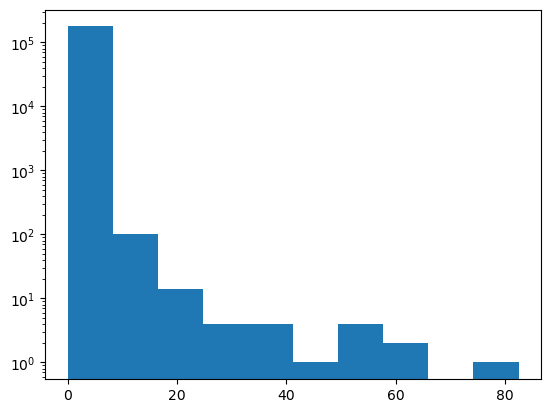

In [18]:
plt.hist(SIMBA_data_bar.T_U)
plt.yscale('log')

# Normal Analysis

In [19]:
import array
halos_bar_all = data_bar[(data_bar.pid == -1)]
halos_dm_all = data_dm[(data_dm.pid == -1)]
print('all halos=',len(halos_bar_all))
#min_mass_hbar = halos_bar_all.M200b.min()
min_mass_hbar = 10**10
#max_mass_hbar = halos_bar_all.M200b.max()
max_mass_hbar = 10**11.6
mw_mass_i = np.log10(max_mass_hbar)
mw_mass_f = np.log10(10**12.6)
bin_4_i = mw_mass_f
bin_4_f = np.log10(halos_bar_all.M200b.max())
bin_4_f_10 = 10**bin_4_f
bin2_M_bar = [bin_4_i,bin_4_f]
print("%.4g"% min_mass_hbar,"%.4g"% bin_4_f_10)
nbins = 2
bins = np.arange(nbins)
del_logM_bar = np.asarray((np.log10(max_mass_hbar)-np.log10(min_mass_hbar))/nbins)
bins_M_bar = [np.log10(min_mass_hbar)]
name = []
for i in bins+1:
    bins_M_bar.append(np.log10(min_mass_hbar)+ i*del_logM_bar)
    name.append('halos_binM_bar'+'_'+str(i))
print(bins_M_bar,bin2_M_bar)
bins_M_bar = np.asarray(bins_M_bar+bin2_M_bar)
bins_M_bar_10 = np.asarray(10**bins_M_bar)
print(bins_M_bar)
font1 = {'color':  'red',
        'weight': 'normal',
        'size': 13,
        }
font2 = {'color':  'darkmagenta',
        'weight': 'normal',
        'size': 13,
        }
font3 = {'color':  'darkgreen',
        'weight': 'normal',
        'size': 13,
        }
font4 = {'color':  'black',
        'weight': 'normal',
        'size': 12.5,
        }
nbins = 3
bins = np.arange(nbins)
for i in bins:
    print(i,'Mass range:',"%.4g"% 10**bins_M_bar[i],"%.4g"% 10**bins_M_bar[i+1])
    halos_bar = halos_bar_all[(np.log10(halos_bar_all.M200b) >= bins_M_bar[i]) & (np.log10(halos_bar_all.M200b) < bins_M_bar[i+1])]               
    #halos_dm = halos_dm_all[(np.log10(halos_dm_all.M200b) >= bins_M_bar[i]) & (np.log10(halos_dm_all.M200b) < bins_M_bar[i+1])]               
    halos_dm = halos_dm_all[(np.log10(halos_dm_all.M200b02d) >= bins_M_bar[i]) & (np.log10(halos_dm_all.M200b02d) < bins_M_bar[i+1])]               
    print('# halos bar:',len(halos_bar),'# halos dm:',len(halos_dm))
    
    cg = ConditionalMultiVariateGaussian()
    x_train = np.asarray(halos_bar[['TidalForce']]) #np.random.randn(100000,2) ## this could be 100000 baryonified haloes with 2 input properties
    y_train = np.asarray(halos_bar[['cv','Spin','ca','ba']]) #np.random.randn(100000,3) ## this could be 100000 baryonified haloes with 3 output properties
    x_test  = np.asarray(halos_dm[['TidalForce']]) #np.random.randn(20000,2)   ## this could be 20000 dm haloes with 2 input properties


    print (x_train.shape)
    print (y_train.shape)
    cg.fit(x_train,y_train)
    y_pred = cg.predict(x_test)
    print(y_pred.shape)
    valy1,edge1,edge2 = np.histogram2d(halos_dm.cv, halos_dm.ba, bins=30, density = False)
    edgex = am(edge1)
    edgey = am(edge2)
    pylab.figure(num = None, figsize = (8, 6), dpi=80, facecolor = 'w', edgecolor = 'k')

    plt.plot(halos_bar.cv, halos_bar.ba,'.',label = "Astrid CV")
    plt.plot(halos_dm.cv, halos_dm.ba,'.',label = "Astrid CV")
    #plt.text(0.18,80, [bins_M_bar[i],bins_M_bar[i+1]], fontsize=11, fontdict=font2)
    #plt.text(0.18,80,["M200b".format(bins_M_bar[i],bins_M_bar[i+1])])

    #plt.contour(edgex, edgey, valy1.T / np.sum(valy1), levels = 5, cmap = 'Purples')
    #plt.colorbar()

    lvl = confidence_intervals(valy1.T/valy1.sum())
    plt.contour(edgex, edgey,valy1.T/valy1.sum(),levels=lvl,cmap='Reds')
    plt.colorbar()

    plt.title('Astrid & Astrid_DM', fontsize = 13)
    plt.legend(loc = 0, borderaxespad = 1.)
    plt.xlabel('c', fontsize=13)
    plt.ylabel(r'$b/a$', fontsize=13)
    #plt.xscale('log')
    #plt.yscale('log')
    #fig.savefig('fig1.png')
    pylab.figure(num = None, figsize = (8, 6), dpi=80, facecolor = 'w', edgecolor = 'k')

    plt.plot(halos_bar.cv, halos_bar.Rvir,'.',label = "Astrid CV")
    plt.plot(halos_dm.cv, halos_dm.Rvir,'.',label = "Astrid_DM CV")

    plt.title('Astrid & Astrid_DM', fontsize = 13)
    plt.legend(loc = 0, borderaxespad = 1.)
    plt.xlabel('c', fontsize=13)
    plt.ylabel(r'$R_{vir}$', fontsize=13)
    bins = 15
    ##spin vs conc
    ca_range   = [0.25, 1.05]
    conc_range = [0.1, 30]
    ba_range   = [0.45, 1.05]
    spin_range = [0, 0.1]
    rvir_range = [120, 200]
    density    = False
    valy1,edge1,edge2 = np.histogram2d(halos_bar.Spin, halos_bar.cv, bins=bins, range = [ spin_range,conc_range],density=density)
    valx1,edge1,edge2 = np.histogram2d(halos_dm.Spin, halos_dm.cv, bins=bins, range = [ spin_range,conc_range],density=density)
    valp1,edge1,edge2 = np.histogram2d(y_pred[:,1], y_pred[:,0], bins=bins, range = [ spin_range,conc_range],density=density)
    edgex = am(edge1)
    edgey = am(edge2)
    #%print (edgey)

    ## vs c/a
    _2valy1,edge1,edge2 = np.histogram2d(halos_bar.Spin, halos_bar.ca, bins=bins, range = [ spin_range,ca_range],density=density)
    _2valx1,edge1,edge2 = np.histogram2d(halos_dm.Spin, halos_dm.ca, bins=bins, range = [ spin_range,ca_range],density=density)
    _2valp1,edge1,edge2 = np.histogram2d(y_pred[:,1], y_pred[:,2], bins=bins, range = [ spin_range,ca_range],density=density)
    _2edgex = am(edge1)
    _2edgey = am(edge2)
    #%


    _3valy1,edge1,edge2 = np.histogram2d(halos_bar.Spin, halos_bar.ba, bins=bins, range = [ spin_range,ba_range],density=density)
    _3valx1,edge1,edge2 = np.histogram2d(halos_dm.Spin, halos_dm.ba, bins=bins, range = [ spin_range,ba_range],density=density)
    _3valp1,edge1,edge2 = np.histogram2d(y_pred[:,1], y_pred[:,3], bins=bins, range = [ spin_range,ba_range],density=density)
    _3edgex = am(edge1)
    _3edgey = am(edge2)

    ## halo concentration vs c/a
    _4valy1,edge1,edge2 = np.histogram2d(halos_bar.cv, halos_bar.ca, bins=bins, range = [ conc_range,ca_range],density=density)
    _4valx1,edge1,edge2 = np.histogram2d(halos_dm.cv, halos_dm.ca, bins=bins, range = [ conc_range,ca_range],density=density)
    _4valp1,edge1,edge2 = np.histogram2d(y_pred[:,0], y_pred[:,2], bins=bins, range = [ conc_range,ca_range],density=density)
    _4edgex = am(edge1)
    _4edgey = am(edge2)

    ## halo concentration vs b/a
    _5valy1,edge1,edge2 = np.histogram2d(halos_bar.cv, halos_bar.ba, bins=bins, range = [ conc_range,ba_range],density=density)
    _5valx1,edge1,edge2 = np.histogram2d(halos_dm.cv, halos_dm.ba, bins=bins, range = [ conc_range,ba_range],density=density)
    _5valp1,edge1,edge2 = np.histogram2d(y_pred[:,0], y_pred[:,3], bins=bins, range = [ conc_range,ba_range],density=density)
    _5edgex = am(edge1)
    _5edgey = am(edge2)

    ## ca vs b/a
    _6valy1,edge1,edge2 = np.histogram2d(halos_bar.ca, halos_bar.ba, bins=bins, range = [ ca_range,ba_range],density=density)
    _6valx1,edge1,edge2 = np.histogram2d(halos_dm.ca, halos_dm.ba, bins=bins, range = [ ca_range,ba_range],density=density)
    _6valp1,edge1,edge2 = np.histogram2d(y_pred[:,2], y_pred[:,3], bins=bins, range = [ ca_range,ba_range],density=density)

    _6edgex = am(edge1)
    _6edgey = am(edge2)
    import matplotlib

    cmap = matplotlib.cm.get_cmap('Purples')
    colorp = [cmap(0.3), cmap(0.4),cmap(0.5),cmap(1.0)]
    colorpp = [cmap(0.3), cmap(0.4),cmap(0.5),cmap(0.9)]
    cmap = matplotlib.cm.get_cmap('binary')
    colorb = [ cmap(0.6),cmap(0.6),cmap(0.6),cmap(0.6)]
    #colorbb = [ cmap(0.6),cmap(0.6),cmap(0.6),cmap(0.6)]
    cmap = matplotlib.cm.get_cmap('Oranges')
    coloro = [cmap(0.3), cmap(0.5),cmap(0.7),cmap(0.8)]
    coloroo = [cmap(0.3), cmap(0.5),cmap(0.7),cmap(0.89)]

    #colorp = colorp[1:]
    #colorb = colorb[1:]
    #coloro = coloro[1:]

    def easyplot(valx,valy,valp,edgex,edgey,lrview=True,predview=True):
        alpha=0.26
        if lrview ==True:
            lvl = confidence_intervals(valx.T/valx.sum())
            ax.contourf(edgex,edgey,valx.T/valx.sum(),colors=colorp,levels=lvl,alpha=alpha)
            c1 = ax.contour(edgex,edgey,valx.T/valx.sum(),levels=lvl,colors=colorpp,linewidths=3)
            h1,l1 = c1.legend_elements()
        else:
            h1=None
        lvl = confidence_intervals(valy.T/valy.sum())
        ax.contourf(edgex,edgey,valy.T/valy.sum(),levels=lvl,colors=coloroo,alpha=alpha)
        c2 = ax.contour(edgex,edgey,valy.T/valy.sum(),levels=lvl,colors=coloro,linewidths=3)
        h2,l1 = c2.legend_elements()
        if predview == True:
            lvl = confidence_intervals(valp.T/valp.sum())
            CS = ax.contour(edgex,edgey,valp.T/valp.sum(),levels=lvl,colors=colorb,linewidths=4,linestyles='dashed')
            h3,l3 = CS.legend_elements()
            for c in CS.collections:
                c.set_dashes([(1,(3.0,3.0))])
        else:
            h3=None
        return h1,h2,h3
    ######################
    import time
    t = time.time()

    from matplotlib import pyplot as plt
    from matplotlib import ticker, cm
    #%from matplotlib import rc

    #%rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    #%rc('text', usetex=True)

    lvl = [0.0014,0.0028,0.0035,1]
    lvl = 3
    lvl = [0.0014,0.0028,0.01]
    #alpha=0.25

    vmax = 0.008
    vmaxcont = 0.005

    fig,axs  = plt.subplots(3,3,figsize=(15,15),gridspec_kw={ 'wspace':0,'hspace': 0},sharex='col',sharey='row')
    #ax = axs[0,0]
    axs[0, 2].axis('off')
    axs[0, 1].axis('off')
    axs[1, 2].set_visible(False)

    ax = axs[0,0]
    h1,h2,h3 = easyplot(valx1,valy1,valp1,edgex,edgey)
    axs[0,0].yaxis.set_ticks_position('both')
    axs[0,0].tick_params(axis='x', direction='in')
    axs[0,0].tick_params(axis='y', direction='in')
    axs[0,0].xaxis.set_ticks_position('both')
    axs[0,0].set_ylabel('Halo Concentration',fontsize=20)
    #1.29760000e+08 1.39624431e+10 1.50238762e+12 1.61660000e+14
    if i ==0:
        axs[0,0].text(1.5,0.3, '$ 10^{10} < M_{200b}/M_{\odot}h^{-1} < 6.3 \\times 10^{10}$', transform = axs[0,0].transAxes, fontsize = 25)
        axs[0,0].text(1.5,0.1, '$x_{train}$: Tidal Force', transform = axs[0,0].transAxes, fontsize = 25)

    if i ==1:
        axs[0,0].text(1.5,0.3, '$6.3 \\times 10^{10} < M_{200b}/M_{\odot}h^{-1} < 4 \\times 10^{11}$', transform = axs[0,0].transAxes, fontsize = 25)
        axs[0,0].text(1.5,0.1, '$x_{train}$: Tidal Force', transform = axs[0,0].transAxes, fontsize = 25)

    if i ==2:
        axs[0,0].text(1.5,0.3, '$4 \\times 10^{11} < M_{200b}/M_{\odot}h^{-1} < 4 \\times 10^{12}$', transform = axs[0,0].transAxes, fontsize = 25)
        axs[0,0].text(1.5,0.1, '$x_{train}$: Tidal Force', transform = axs[0,0].transAxes, fontsize = 25)

    if i ==3:
        axs[0,0].text(1.5,0.3, '$4 \\times 10^{12} < M_{200b}/M_{\odot}h^{-1} < 4 \\times 10^{14}$', transform = axs[0,0].transAxes, fontsize = 25)
        axs[0,0].text(1.5,0.1, '$x_{train}$: Tidal Force', transform = axs[0,0].transAxes, fontsize = 25)
          
    if h3 is not None:
        axs[0,0].legend([h1[-2], h2[-2],h3[-2]], ['DM Haloes', 'Baryonic Haloes','Our-Prediction (for DM haloes)'],fontsize=25,bbox_to_anchor=(3.05, 1))
    else:
        axs[0,0].legend([h1[-2], h2[-2]], ['DM Haloes', 'Baryonic Haloes'],fontsize=25,bbox_to_anchor=(3.05, 1))
        axs[0,0].text(2,0.5, '$2 \\times 10^{11} < M_{200}/M_{\odot}h^{-1} < 10^{12}$', transform = axs[0,0].transAxes, fontsize = 25)

    #axs[1, 0].contourf(_2edgex,_2edgey,_2valy.T/_2valy.sum(),vmin=0,vmax=vmax,levels=lvl,cmap='Oranges',alpha=alpha)
    #axs[1, 0].contour(_2edgex,_2edgey,_2valy.T/_2valy.sum(),vmin=0,vmax=vmaxcont,levels=lvl,cmap='Oranges',linewidths=3)
    #axs[1, 0].contourf(_2edgex,_2edgey,_2valx.T/_2valx.sum(),vmin=0,vmax=vmax,levels=lvl,cmap='Purples',alpha=alpha)
    #axs[1, 0].contour(_2edgex,_2edgey,_2valx.T/_2valx.sum(),vmin=0,vmax=vmaxcont,levels=lvl,cmap='Purples',linewidths=3)
    axs[1,0].set_ylabel('Halo Shape c/a',fontsize=20)
    #CS = axs[1, 0].contour(_2edgex,_2edgey,_2valp.T/_2valp.sum(),vmin=0,vmax=vmaxcont,levels=lvl,cmap='binary',linewidths=3.5,linestyles='dotted')
    ax = axs[1,0]
    easyplot(_2valx1,_2valy1,_2valp1,_2edgex,_2edgey)
    axs[1,0].yaxis.set_ticks_position('both')
    axs[1,0].tick_params(axis='x', direction='in')
    axs[1,0].tick_params(axis='y', direction='in')
    axs[1,0].xaxis.set_ticks_position('both')
    #for c in CS.collections:
    #    c.set_dashes([(11, (3.0, 3.0))])


    #axs[2, 0].contourf(_3edgex,_3edgey,_3valy.T/_3valy.sum(),vmin=0,vmax=vmax,levels=lvl,cmap='Oranges',alpha=alpha)
    #axs[2, 0].contour(_3edgex,_3edgey,_3valy.T/_3valy.sum(),vmin=0,vmax=vmaxcont,levels=lvl,cmap='Oranges',linewidths=3)
    #axs[2, 0].contourf(_3edgex,_3edgey,_3valx.T/_3valx.sum(),vmin=0,vmax=vmax,levels=lvl,cmap='Purples',alpha=alpha)
    #axs[2, 0].contour(_3edgex,_3edgey,_3valx.T/_3valx.sum(),vmin=0,vmax=vmaxcont,levels=lvl,cmap='Purples',linewidths=3)
    ax = axs[2,0]
    easyplot(_3valx1,_3valy1,_3valp1,_3edgex,_3edgey)
    axs[2,0].set_ylabel('Halo Shape b/a',fontsize=20)
    axs[2,0].yaxis.set_ticks_position('both')
    axs[2,0].tick_params(axis='x', direction='in')
    axs[2,0].tick_params(axis='y', direction='in')
    axs[2,0].xaxis.set_ticks_position('both')
    #CS = axs[2, 0].contour(_3edgex,_3edgey,_3valp.T/_3valp.sum(),vmin=0,vmax=vmaxcont,levels=lvl,cmap='binary',linewidths=3,linestyles='dotted')
    #for c in CS.collections:
    #    c.set_dashes([(11, (3.0, 3.0))])
    axs[2,0].set_xlabel('Halo Spin',fontsize=20)


    ## halo conc vs c/a
    #axs[1, 1].contourf(_4edgex,_4edgey,_4valy.T/_4valy.sum(),vmin=0,vmax=vmax,levels=lvl,cmap='Oranges',alpha=alpha)
    #axs[1, 1].contour(_4edgex,_4edgey,_4valy.T/_4valy.sum(),vmin=0,vmax=vmaxcont,levels=lvl,cmap='Oranges',linewidths=3)
    #axs[1, 1].contourf(_4edgex,_4edgey,_4valx.T/_4valx.sum(),vmin=0,vmax=vmax,levels=lvl,cmap='Purples',alpha=alpha)
    #axs[1, 1].contour(_4edgex,_4edgey,_4valx.T/_4valx.sum(),vmin=0,vmax=vmaxcont,levels=lvl,cmap='Purples',linewidths=3)
    ax = axs[1,1]
    easyplot(_4valx1,_4valy1,_4valp1,_4edgex,_4edgey)

    axs[1,1].yaxis.set_ticks_position('both')
    axs[1,1].tick_params(axis='x', direction='in')
    axs[1,1].tick_params(axis='y', direction='in')
    axs[1,1].xaxis.set_ticks_position('both')
    #CS = axs[1, 1].contour(_4edgex,_4edgey,_4valp.T/_4valp.sum(),vmin=0,vmax=vmax,levels=lvl,cmap='binary',linewidths=3,linestyles='dotted')
    #for c in CS.collections:
    #    c.set_dashes([(11, (3.0, 3.0))])


    ## halo conc vs b/a
    #axs[2, 1].contourf(_5edgex,_5edgey,_5valy.T/_5valy.sum(),vmin=0,vmax=vmax,levels=lvl,cmap='Oranges',alpha=alpha)
    #axs[2, 1].contour(_5edgex,_5edgey,_5valy.T/_5valy.sum(),vmin=0,vmax=vmaxcont,levels=lvl,cmap='Oranges',linewidths=3)
    #axs[2, 1].contourf(_5edgex,_5edgey,_5valx.T/_5valx.sum(),vmin=0,vmax=vmax,levels=lvl,cmap='Purples',alpha=alpha)
    #axs[2, 1].contour(_5edgex,_5edgey,_5valx.T/_5valx.sum(),vmin=0,vmax=vmaxcont,levels=lvl,cmap='Purples',linewidths=3)
    axs[2,1].yaxis.set_ticks_position('both')
    axs[2,1].tick_params(axis='x', direction='in')
    axs[2,1].tick_params(axis='y', direction='in')
    axs[2,1].xaxis.set_ticks_position('both')
    #CS = axs[2, 1].contour(_5edgex,_5edgey,_5valp.T/_5valp.sum(),vmin=0,vmax=vmaxcont,levels=lvl,cmap='binary',linewidths=3,linestyles='dotted')
    #for c in CS.collections:
    #    c.set_dashes([(11, (3.0, 3.0))])
    axs[2, 1].set_xlabel('Halo Concentration',fontsize=20)
    ax = axs[2,1]
    easyplot(_5valx1,_5valy1,_5valp1,_5edgex,_5edgey)


    ## halo conc vs b/a
    #axs[2, 2].contourf(_6edgex,_6edgey,_6valy.T/_6valy.sum(),vmin=0,vmax=vmax,levels=lvl,cmap='Oranges',alpha=alpha)
    #axs[2, 2].contour(_6edgex,_6edgey,_6valy.T/_6valy.sum(),vmin=0,vmax=vmaxcont,levels=lvl,cmap='Oranges',linewidths=3)
    #axs[2, 2].contourf(_6edgex,_6edgey,_6valx.T/_6valx.sum(),vmin=0,vmax=vmax,levels=lvl,cmap='Purples',alpha=alpha)
    #axs[2, 2].contour(_6edgex,_6edgey,_6valx.T/_6valx.sum(),vmin=0,vmax=vmaxcont,levels=lvl,cmap='Purples',linewidths=3)
    axs[2,2].yaxis.set_ticks_position('both')
    axs[2,2].tick_params(axis='x', direction='in')
    axs[2,2].tick_params(axis='y', direction='in')
    axs[2,2].xaxis.set_ticks_position('both')
    #CS = axs[2, 2].contour(_6edgex,_6edgey,_6valp.T/_6valp.sum(),vmin=0,vmax=vmaxcont,levels=lvl,cmap='binary',linewidths=3,linestyles='dotted')
    #for c in CS.collections:
    #    c.set_dashes([(11, (3.0, 3.0))])
    ax = axs[2,2]
    x = np.linspace(0, 1.1, 4)
    y = x
    plt.fill_between(x, y, where=(x > 0), color='grey', alpha=0.1)
    ax.set_xlim([0.3,1.05])
    ax.set_ylim([0.38,1.05])

    easyplot(_6valx1,_6valy1,_6valp1,_6edgex,_6edgey)


    axs[2, 2].set_xlabel('Halo Shape c/a',fontsize=20)
    #axs[0, 0].contourf(edgex,edgey,valp.T,vmin=0,vmax=1.5,levels=lvl,cmap='Purples',alpha=0.5)


    #plt.subplots_adjust(hspace=.0)
    #axs[0,0].grid()
    #axs[1,0].grid()
    #axs[1,1].grid()
    #axs[2,0].grid()
    #axs[2,1].grid()
    #axs[2,2].grid()
    #print (time.time()-t)

    plt.savefig('Astrid_BarVsDM'+str(i)+'_TF_HMFDEX.pdf')
    
    
    #check dm halo concentrations
    meanHdms = stats.binned_statistic(np.log10(halos_dm.M200b02d),np.log10(halos_dm.M200b02d),statistic='mean', bins=11, range=(halos_bar.M200b.min(),halos_bar.M200b.max()))
    meanHdm = 10**meanHdms[0]
    cvmdms = stats.binned_statistic(np.log10(halos_dm.M200b02d),np.log10(halos_dm.cv),statistic='median', bins=11,range=(halos_bar.M200b.min(),halos_bar.M200b.max()))
    cvm_dm_sim = 10**cvmdms[0]
    cvmdms_pred = stats.binned_statistic(np.log10(halos_dm.M200b02d),np.log10(y_pred[:,0]),statistic='median', bins=11,range=(halos_bar.M200b.min(),halos_bar.M200b.max()))
    cvm_dm_pred = 10**cvmdms_pred[0]
    pylab.figure(num = None, figsize = (8, 6), dpi=80, facecolor = 'w', edgecolor = 'k')
    #plt.plot(halos_dm.M200b, halos_dm.cv,'.',label = "simulations")
    #plt.plot(halos_dm.M200b, y_pred[:,0],'.',label = "our-prediction")
    plt.plot(meanHdm, cvm_dm_sim,'-',label = "simulations")
    plt.plot(meanHdm, cvm_dm_pred,'-',label = "our-prediction")

NameError: name 'data_bar' is not defined

In [ ]:
bins_M_bar = [10., 10.8, 11.6, 12.6, 14.208]

In [ ]:
ind = np.random.choice(len(halos_bar), 10000)

In [ ]:
halos_bar

In [ ]:
halos_bar.iloc[ind].cv

0 Mass range: 1e+10 6.31e+10
# halos bar: 67758 # halos dm: 71925
here
acceptance rate is  87.67278578219849 %
pval (Bar-DM) = 6.880788139825982e-66
pval (Bar-pred) = 0.02983643245840902
pval (Bar-DM) = 0.352690607768387
pval (Bar-pred) = 0.33994536027287675
pval (Bar-DM) = 0.0
pval (Bar-pred) = 0.025025587971155453
pval (Bar-DM) = 3.740970354337083e-301
pval (Bar-pred) = 1.5047079132833436e-09


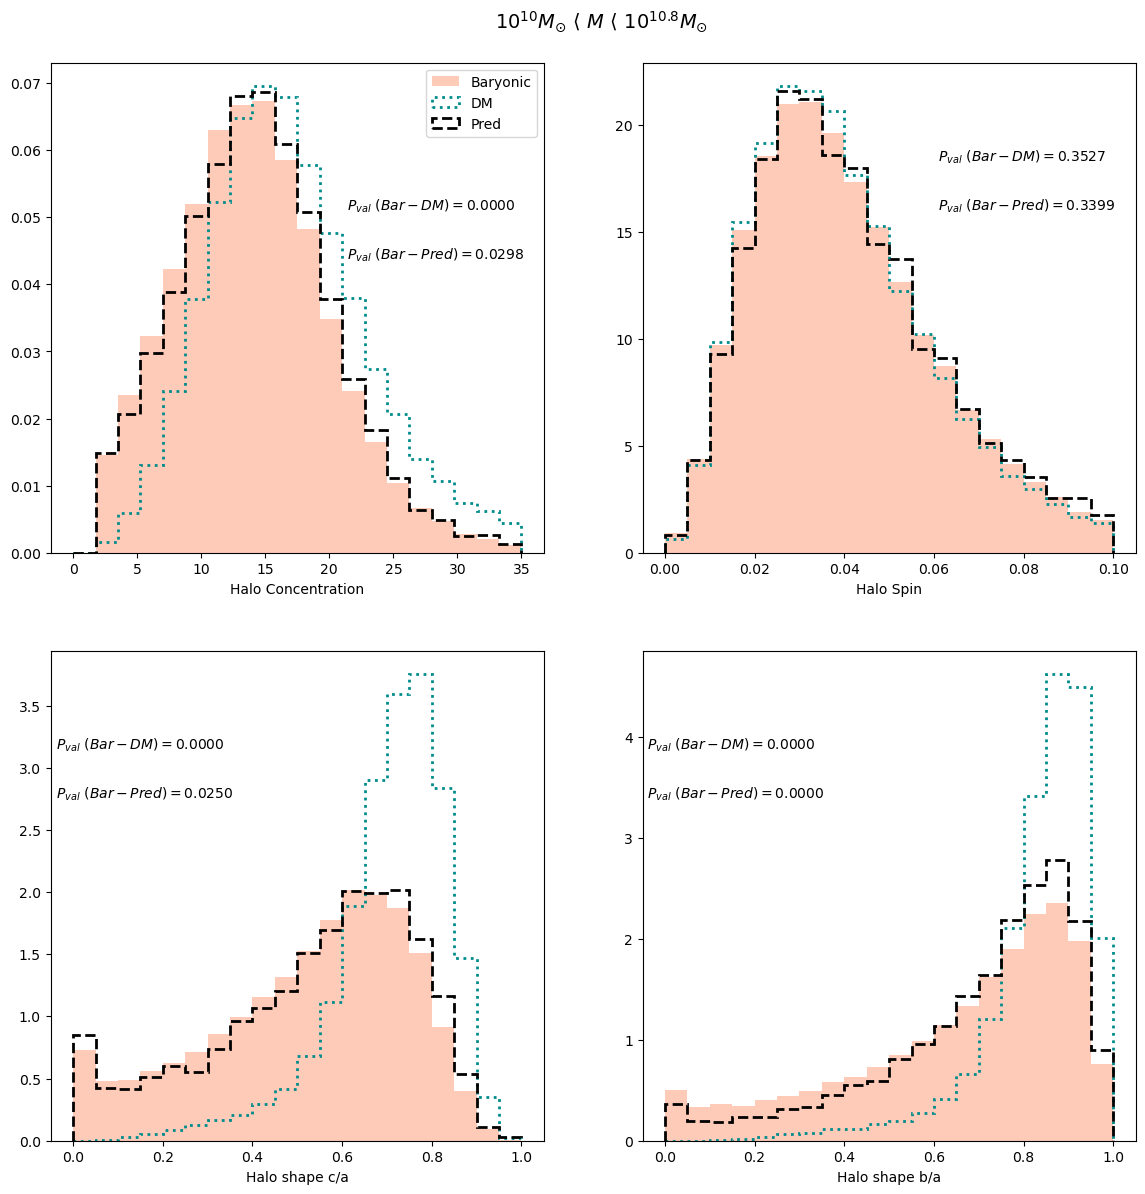

1 Mass range: 6.31e+10 3.981e+11
# halos bar: 15958 # halos dm: 14878
here
acceptance rate is  90.72504421001281 %
pval (Bar-DM) = 1.4010825338263892e-54
pval (Bar-pred) = 1.7583389216217802e-06
pval (Bar-DM) = 2.881908702660532e-14
pval (Bar-pred) = 0.1293932411485686
pval (Bar-DM) = 1.6928311217069615e-129
pval (Bar-pred) = 0.0003207898529100509
pval (Bar-DM) = 1.6287905124395238e-58
pval (Bar-pred) = 1.025411117627447e-12


<Figure size 640x480 with 0 Axes>

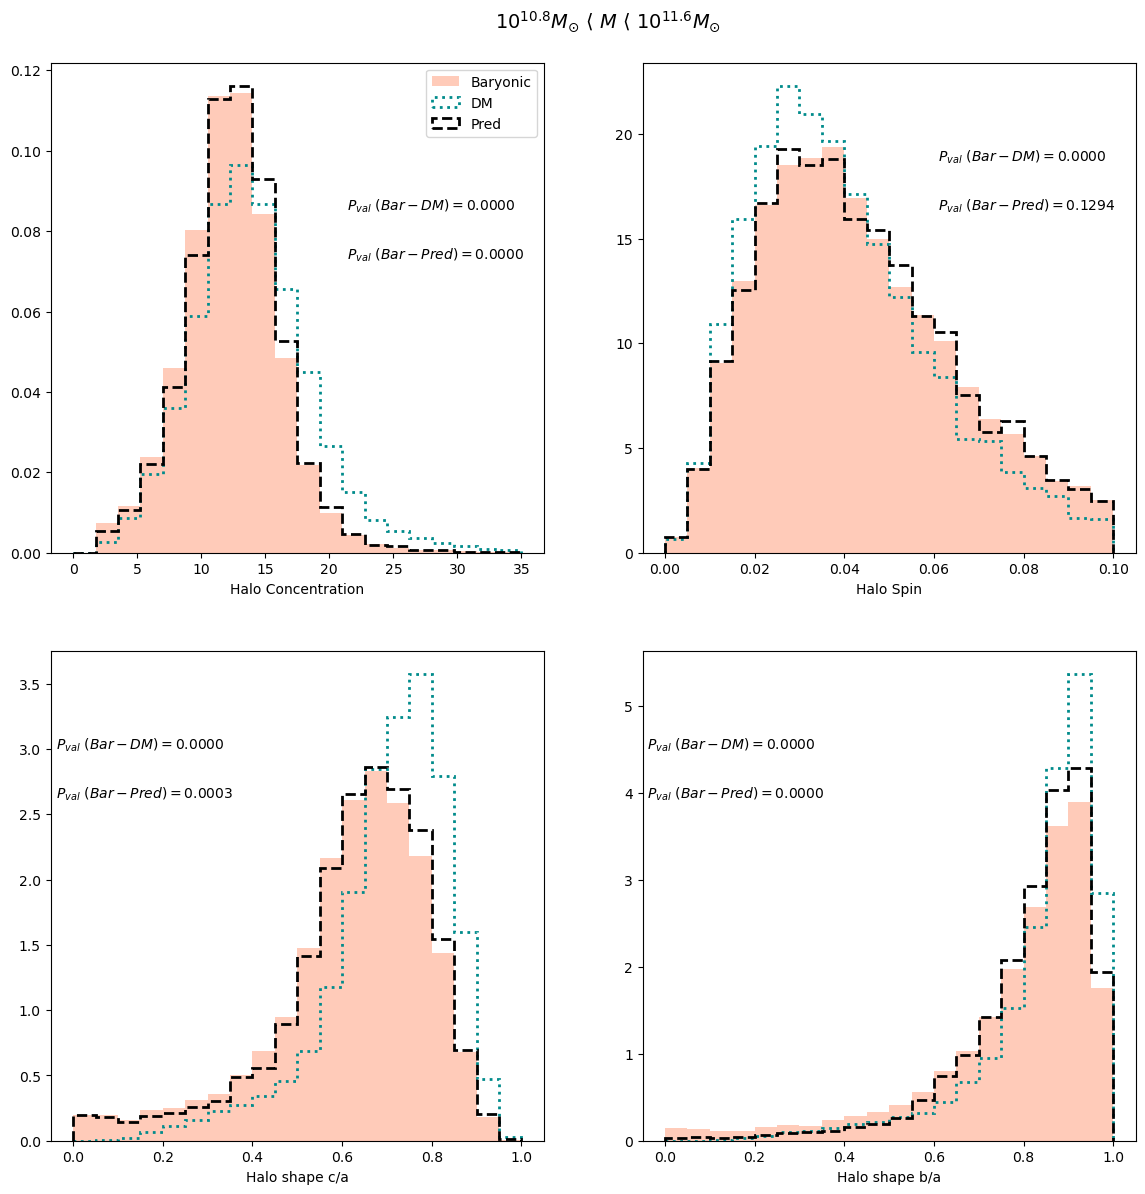

2 Mass range: 3.981e+11 3.981e+12
# halos bar: 3690 # halos dm: 3242
here
acceptance rate is  90.0805779383162 %
pval (Bar-DM) = 3.397664342239417e-11
pval (Bar-pred) = 0.04240533889859493
pval (Bar-DM) = 8.542289244248157e-13
pval (Bar-pred) = 0.7448909307386283
pval (Bar-DM) = 1.7870671316601133e-10
pval (Bar-pred) = 0.007600502216611176
pval (Bar-DM) = 2.1643283574980485e-23
pval (Bar-pred) = 9.802479805295468e-09


<Figure size 640x480 with 0 Axes>

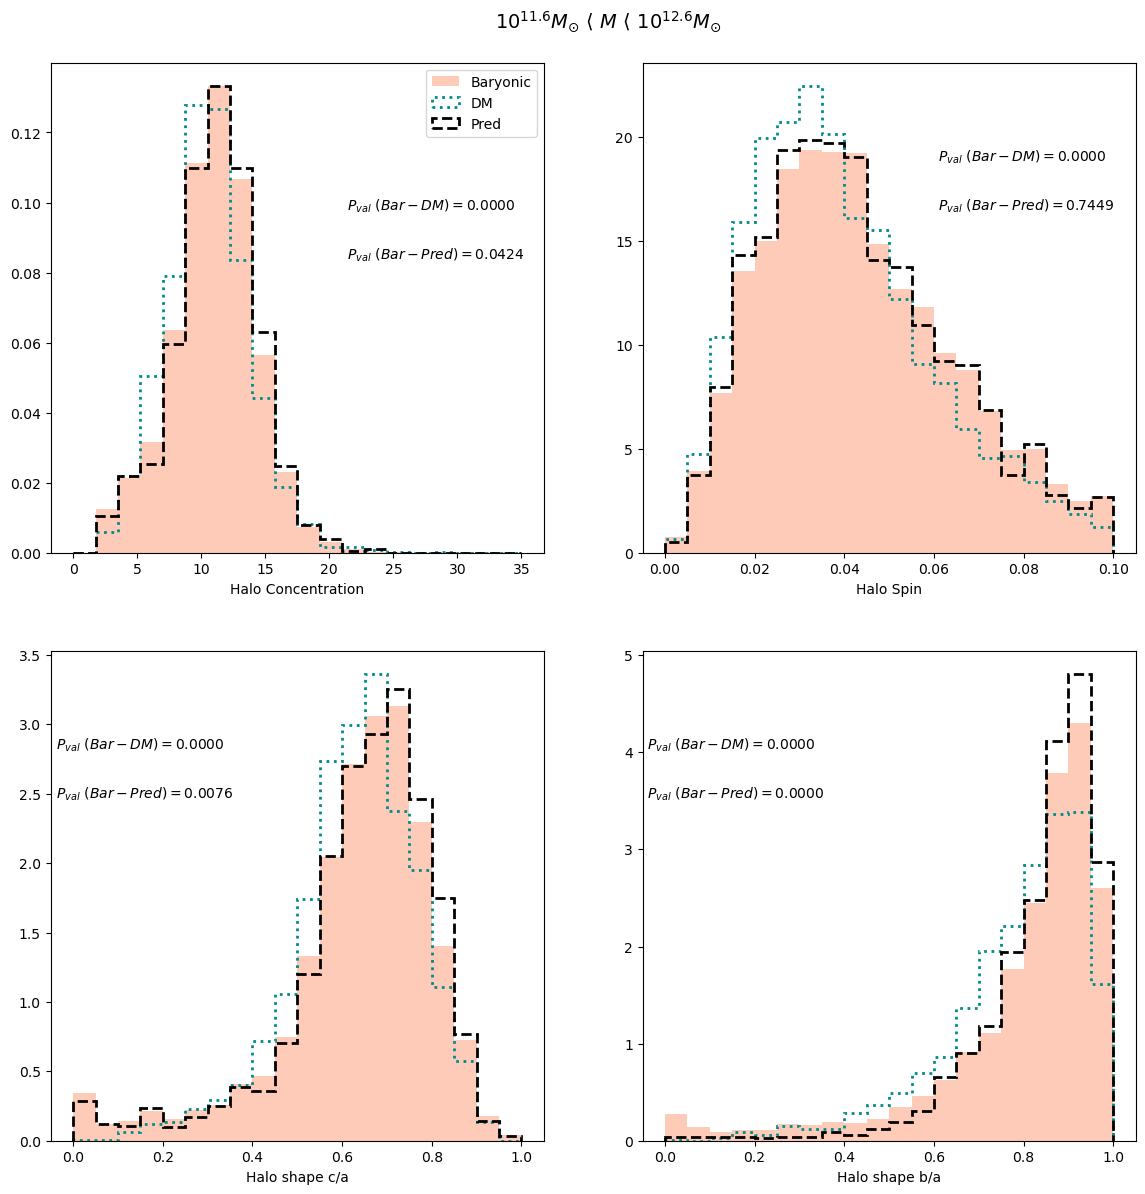

<Figure size 640x480 with 0 Axes>

In [37]:
font1 = {'color':  'red',
        'weight': 'normal',
        'size': 13,
        }
font2 = {'color':  'darkmagenta',
        'weight': 'normal',
        'size': 13,
        }
font3 = {'color':  'darkgreen',
        'weight': 'normal',
        'size': 13,
        }
font4 = {'color':  'black',
        'weight': 'normal',
        'size': 12.5,
        }
nbins = 3
bins = np.arange(nbins)

hist_bins = 20
titles = ['$10^{10} M_{\odot} \ \langle \ M \ \langle \ 10^{10.8} M_{\odot}$',
          '$10^{10.8} M_{\odot} \ \langle \ M \ \langle \ 10^{11.6} M_{\odot}$',
          '$10^{11.6} M_{\odot} \ \langle \ M \ \langle \ 10^{12.6} M_{\odot}$']
for i in bins:
    print(i,'Mass range:',"%.4g"% 10**bins_M_bar[i],"%.4g"% 10**bins_M_bar[i+1])
    halos_bar = halos_bar_all[(np.log10(halos_bar_all.M200b) >= bins_M_bar[i]) & (np.log10(halos_bar_all.M200b) < bins_M_bar[i+1])]        
    halos_dm = halos_dm_all[(np.log10(halos_dm_all.M200b02d) >= bins_M_bar[i]) & (np.log10(halos_dm_all.M200b02d) < bins_M_bar[i+1])]               
    print('# halos bar:',len(halos_bar),'# halos dm:',len(halos_dm))
    
    cg = ConditionalMultiVariateGaussian()
    x_train = np.asarray(halos_bar[['TidalForce']]) #np.random.randn(100000,2) ## this could be 100000 baryonified haloes with 2 input properties
    y_train = np.asarray(halos_bar[['cv','Spin','ca','ba']]) #np.random.randn(100000,3) ## this could be 100000 baryonified haloes with 3 output properties
    x_test  = np.asarray(halos_dm[['TidalForce']]) #np.random.randn(20000,2)   ## this could be 20000 dm haloes with 2 input properties

    cg.fit(x_train,y_train)
    y_pred = cg.predict(x_test)
    
    fig, ax = plt.subplots(2,2, figsize = (14,14))
    
    # CV
    ax[0,0].hist(halos_bar.cv, color = 'coral', lw = 2, bins = hist_bins, range = (0,35), alpha = 0.4, label = 'Baryonic', density = True)
    ax[0,0].hist(halos_dm.cv, histtype = 'step', color = 'darkcyan', lw = 2, bins = hist_bins, range = (0,35), ls = ':', label = 'DM', density = True)
    ax[0,0].hist(y_pred[:,0], histtype = 'step', color = 'black', lw = 2, bins = hist_bins, range = (0,35), ls = '--', label = 'Pred', density = True)

    if len(halos_bar) > 5000: 
        ind_bar = np.random.choice(len(halos_bar), 5000, replace = False)
    else: ind_bar = np.arange(len(halos_bar))
    if len(halos_dm) > 5000: ind_dm = np.random.choice(len(halos_dm), 5000, replace = False)
    else: ind_dm = np.arange(len(halos_dm))
    
    ks = ks_2samp(halos_bar.iloc[ind_bar].cv, halos_dm.iloc[ind_dm].cv)[1]
    print('pval (Bar-DM) = ' + str(ks))
    ax[0,0].text(0.6,0.7, '$P_{val}\ (Bar-DM)=$' + '{:.4f}'.format(ks), transform = ax[0,0].transAxes)
    ks = ks_2samp(halos_bar.iloc[ind_bar].cv, y_pred[ind_dm,0])[1]
    print('pval (Bar-pred) = ' + str(ks))
    ax[0,0].text(0.6,0.6, '$P_{val}\ (Bar-Pred)=$' + '{:.4f}'.format(ks), transform = ax[0,0].transAxes)

    ax[0,0].set_xlabel('Halo Concentration')
    ax[0,0].legend()
    ax[0,0].text(0.9,1.07, titles[i], transform = ax[0,0].transAxes, fontsize = 14)
    
    # Spin
    ax[0,1].hist(halos_bar.Spin, color = 'coral', lw = 2, bins = hist_bins, range = (0,0.1), alpha = 0.4, label = 'Baryonic', density = True)
    ax[0,1].hist(halos_dm.Spin, histtype = 'step', color = 'darkcyan', lw = 2, bins = hist_bins, range = (0,0.1), ls = ':', label = 'DM', density = True)
    ax[0,1].hist(y_pred[:,1], histtype = 'step', color = 'black', lw = 2, bins = hist_bins, range = (0,0.1), ls = '--', label = 'Pred', density = True)

    ks = ks_2samp(halos_bar.iloc[ind_bar].Spin, halos_dm.iloc[ind_dm].Spin)[1]
    print('pval (Bar-DM) = ' + str(ks))
    ax[0,1].text(0.6,0.8, '$P_{val}\ (Bar-DM)=$' + '{:.4f}'.format(ks), transform = ax[0,1].transAxes)
    ks = ks_2samp(halos_bar.iloc[ind_bar].Spin, y_pred[ind_dm,1])[1]
    print('pval (Bar-pred) = ' + str(ks))
    ax[0,1].text(0.6,0.7, '$P_{val}\ (Bar-Pred)=$' + '{:.4f}'.format(ks), transform = ax[0,1].transAxes)

    ax[0,1].set_xlabel('Halo Spin')
    
    # Ca
    ax[1,0].hist(halos_bar.ca, color = 'coral', lw = 2, bins = hist_bins, range = (0,1), alpha = 0.4, label = 'Baryonic', density = True)
    ax[1,0].hist(halos_dm.ca, histtype = 'step', color = 'darkcyan', lw = 2, bins = hist_bins, range = (0,1), ls = ':', label = 'DM', density = True)
    ax[1,0].hist(y_pred[:,2], histtype = 'step', color = 'black', lw = 2, bins = hist_bins, range = (0,1), ls = '--', label = 'Pred', density = True)

    ks = ks_2samp(halos_bar.iloc[ind_bar].ca, halos_dm.iloc[ind_dm].ca)[1]
    print('pval (Bar-DM) = ' + str(ks))
    ax[1,0].text(0.01,0.8, '$P_{val}\ (Bar-DM)=$' + '{:.4f}'.format(ks), transform = ax[1,0].transAxes)
    ks = ks_2samp(halos_bar.iloc[ind_bar].ca, y_pred[ind_dm,2])[1]
    print('pval (Bar-pred) = ' + str(ks))
    ax[1,0].text(0.01,0.7, '$P_{val}\ (Bar-Pred)=$' + '{:.4f}'.format(ks), transform = ax[1,0].transAxes)

    ax[1,0].set_xlabel('Halo shape c/a')
    
    # CV
    ax[1,1].hist(halos_bar.ba, color = 'coral', lw = 2, bins = hist_bins, range = (0,1), alpha = 0.4, label = 'Baryonic', density = True)
    ax[1,1].hist(halos_dm.ba, histtype = 'step', color = 'darkcyan', lw = 2, bins = hist_bins, range = (0,1), ls = ':', label = 'DM', density = True)
    ax[1,1].hist(y_pred[:,3], histtype = 'step', color = 'black', lw = 2, bins = hist_bins, range = (0,1), ls = '--', label = 'Pred', density = True)

    ks = ks_2samp(halos_bar.iloc[ind_bar].ba, halos_dm.iloc[ind_dm].ba)[1]
    print('pval (Bar-DM) = ' + str(ks))
    ax[1,1].text(0.01,0.8, '$P_{val}\ (Bar-DM)=$' + '{:.4f}'.format(ks), transform = ax[1,1].transAxes)
    ks = ks_2samp(halos_bar.iloc[ind_bar].ba, y_pred[ind_dm,3])[1]
    print('pval (Bar-pred) = ' + str(ks))
    ax[1,1].text(0.01,0.7, '$P_{val}\ (Bar-Pred)=$' + '{:.4f}'.format(ks), transform = ax[1,1].transAxes)

    ax[1,1].set_xlabel('Halo shape b/a')
    
    plt.savefig('ASTRID_1d_distributions_' + str(i) + '.pdf')
    plt.show()
    plt.clf()

# Cross-Simulation Analysis

In [19]:
halos_bar_all = Astrid_data_bar[(Astrid_data_bar.pid == -1)]
halos_dm_all = Astrid_data_dm[(Astrid_data_dm.pid == -1)]
print('all halos=',len(halos_bar_all))
#min_mass_hbar = halos_bar_all.M200b.min()
min_mass_hbar = 10**10
#max_mass_hbar = halos_bar_all.M200b.max()
max_mass_hbar = 10**11.6
mw_mass_i = np.log10(max_mass_hbar)
mw_mass_f = np.log10(10**12.6)
bin_4_i = mw_mass_f
bin_4_f = np.log10(halos_bar_all.M200b.max())
bin_4_f_10 = 10**bin_4_f
bin2_M_bar = [bin_4_i,bin_4_f]
print("%.4g"% min_mass_hbar,"%.4g"% bin_4_f_10)
nbins = 2
bins = np.arange(nbins)
del_logM_bar = np.asarray((np.log10(max_mass_hbar)-np.log10(min_mass_hbar))/nbins)
bins_M_bar = [np.log10(min_mass_hbar)]
name = []
for i in bins+1:
    bins_M_bar.append(np.log10(min_mass_hbar)+ i*del_logM_bar)
    name.append('halos_binM_bar'+'_'+str(i))
print(bins_M_bar,bin2_M_bar)
bins_M_bar = np.asarray(bins_M_bar+bin2_M_bar)
bins_M_bar_10 = np.asarray(10**bins_M_bar)
print(bins_M_bar)

all halos= 163185
1e+10 1.593e+14
[10.0, 10.8, 11.6] [12.6, 14.202243037624806]
[10.         10.8        11.6        12.6        14.20224304]


In [20]:
cmap = matplotlib.cm.get_cmap('Purples')
colorp = [cmap(0.3), cmap(0.4),cmap(0.5),cmap(1.0)]
colorpp = [cmap(0.3), cmap(0.4),cmap(0.5),cmap(0.9)]
cmap = matplotlib.cm.get_cmap('binary')
colorb = [ cmap(0.6),cmap(0.6),cmap(0.6),cmap(0.6)]
#colorbb = [ cmap(0.6),cmap(0.6),cmap(0.6),cmap(0.6)]
cmap = matplotlib.cm.get_cmap('Oranges')
coloro = [cmap(0.3), cmap(0.5),cmap(0.7),cmap(0.8)]
coloroo = [cmap(0.3), cmap(0.5),cmap(0.7),cmap(0.89)]


/tmp/ipykernel_443/99238541.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('Purples')
/tmp/ipykernel_443/99238541.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('binary')
/tmp/ipykernel_443/99238541.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('Oranges')


In [21]:
from matplotlib.lines import Line2D
line0 = Line2D([0], [0], color=colorp[3], lw = 4)
line1 = Line2D([0], [0], color='magenta', lw = 4)
line2 = Line2D([0], [0], color=coloro[3], lw = 4)
line3 = Line2D([0], [0], color=colorb[3], lw = 4)

0 Mass range: 1e+10 6.31e+10
# halos bar: 67758 # halos dm: 71925
(67758, 1)
(67758, 4)
here
acceptance rate is  87.50851664395562 %
(71925, 4)


/tmp/ipykernel_443/2316500636.py:121: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('Purples')
/tmp/ipykernel_443/2316500636.py:124: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('binary')
/tmp/ipykernel_443/2316500636.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('Oranges')
/tmp/ipykernel_443/586872839.py:18: MatplotlibDeprecationWarning: The collections attribute was deprecated 

1 Mass range: 6.31e+10 3.981e+11
# halos bar: 15958 # halos dm: 14878
(15958, 1)
(15958, 4)
here
acceptance rate is  90.5153008456531 %
(14878, 4)


/tmp/ipykernel_443/2316500636.py:121: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('Purples')
/tmp/ipykernel_443/2316500636.py:124: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('binary')
/tmp/ipykernel_443/2316500636.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('Oranges')
/tmp/ipykernel_443/586872839.py:18: MatplotlibDeprecationWarning: The collections attribute was deprecated 

2 Mass range: 3.981e+11 3.981e+12
# halos bar: 3690 # halos dm: 3242
(3690, 1)
(3690, 4)
here
acceptance rate is  90.35674470457079 %
(3242, 4)


/tmp/ipykernel_443/2316500636.py:121: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('Purples')
/tmp/ipykernel_443/2316500636.py:124: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('binary')
/tmp/ipykernel_443/2316500636.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('Oranges')
/tmp/ipykernel_443/586872839.py:18: MatplotlibDeprecationWarning: The collections attribute was deprecated 

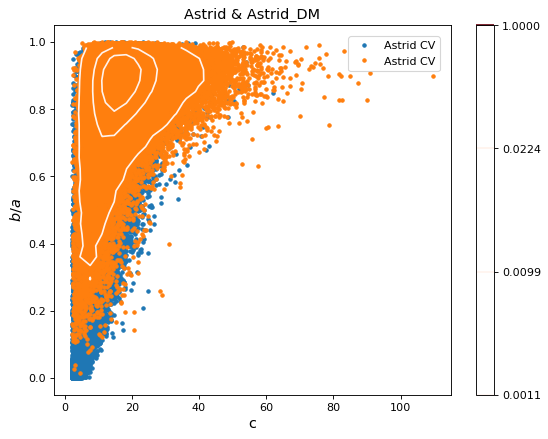

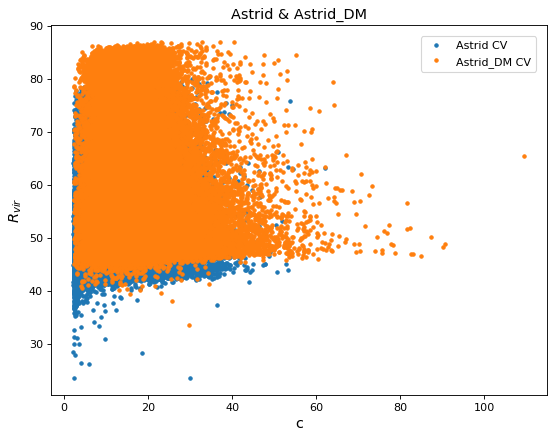

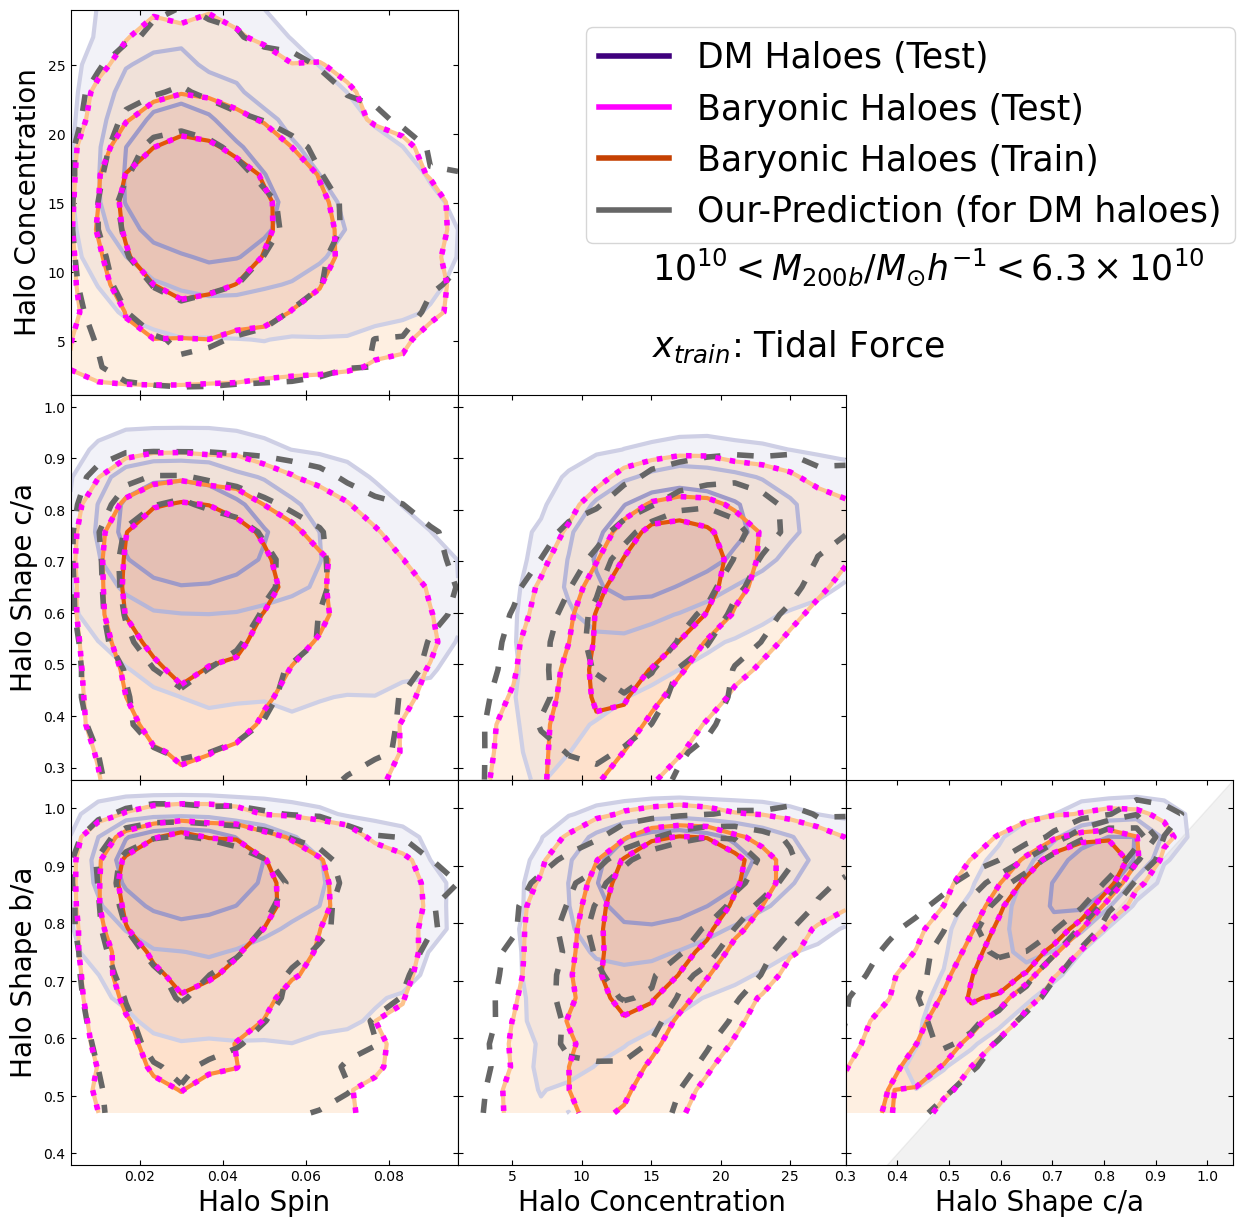

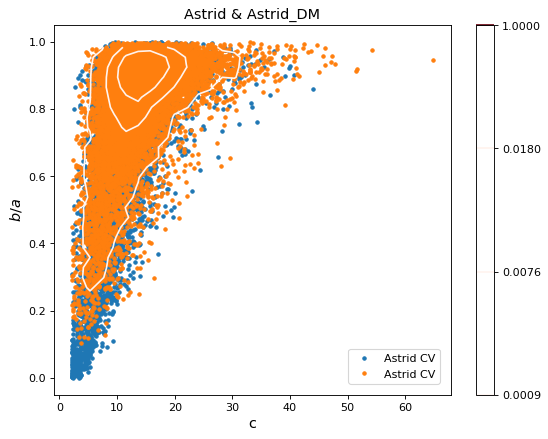

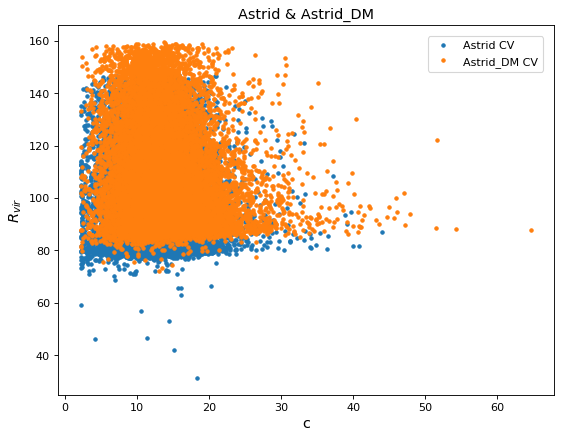

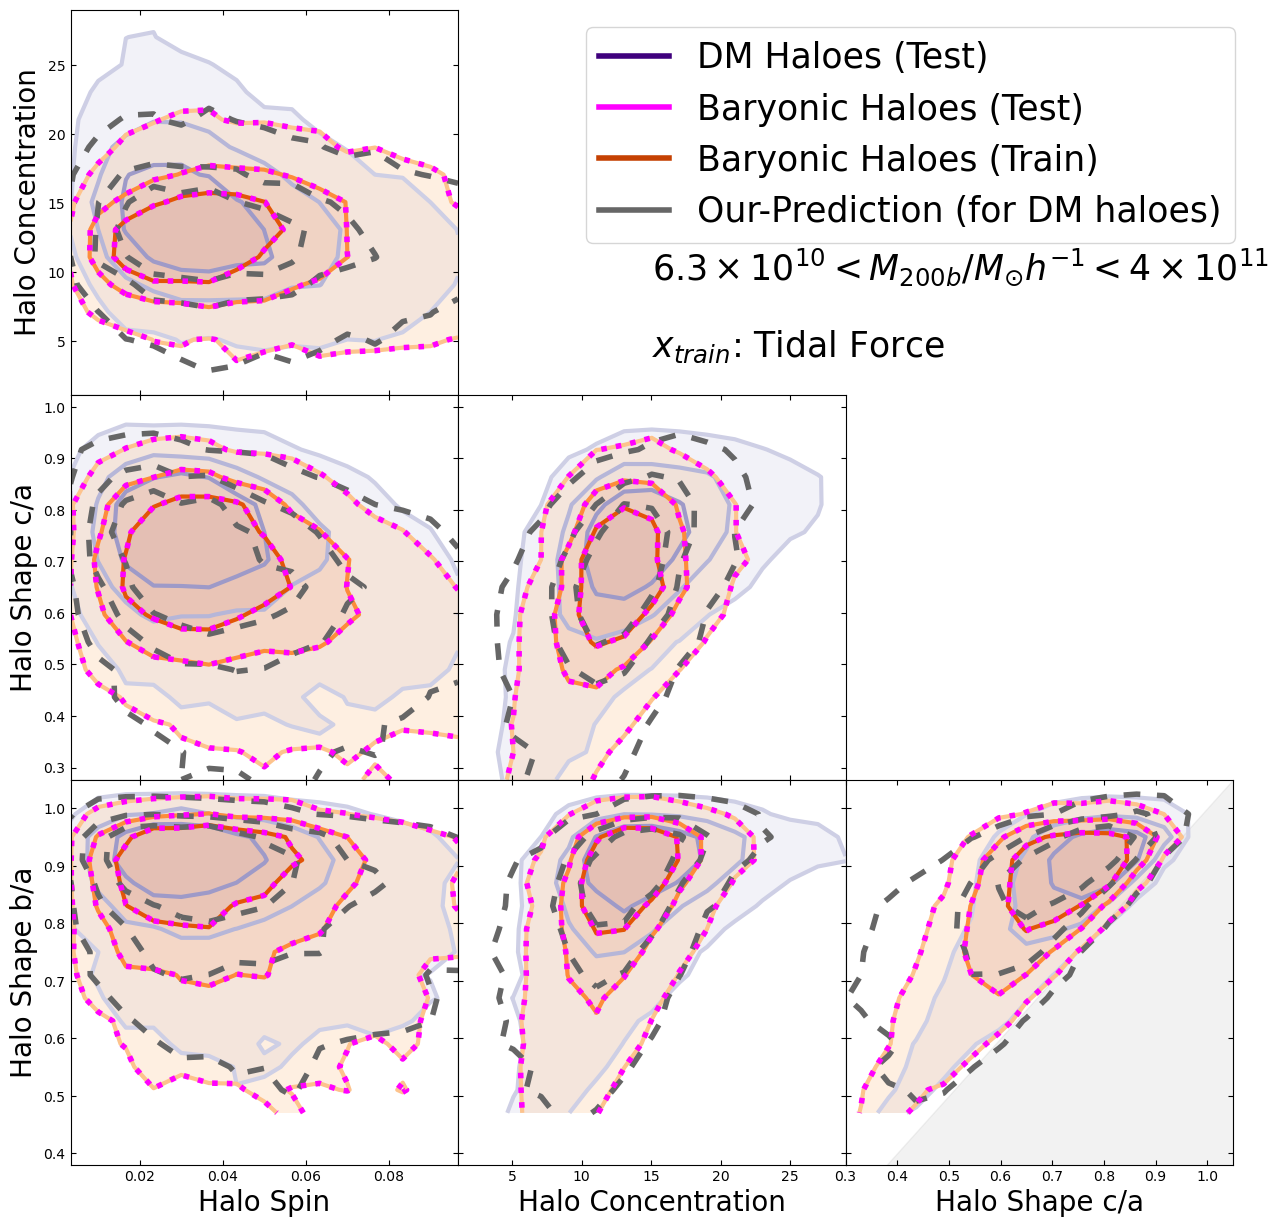

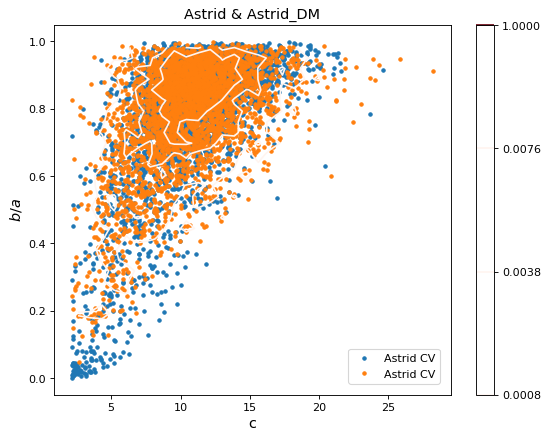

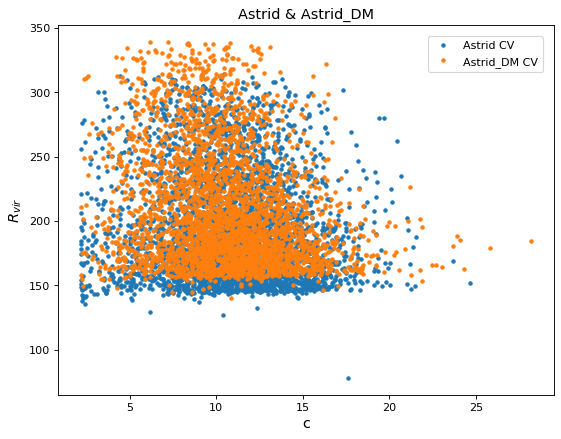

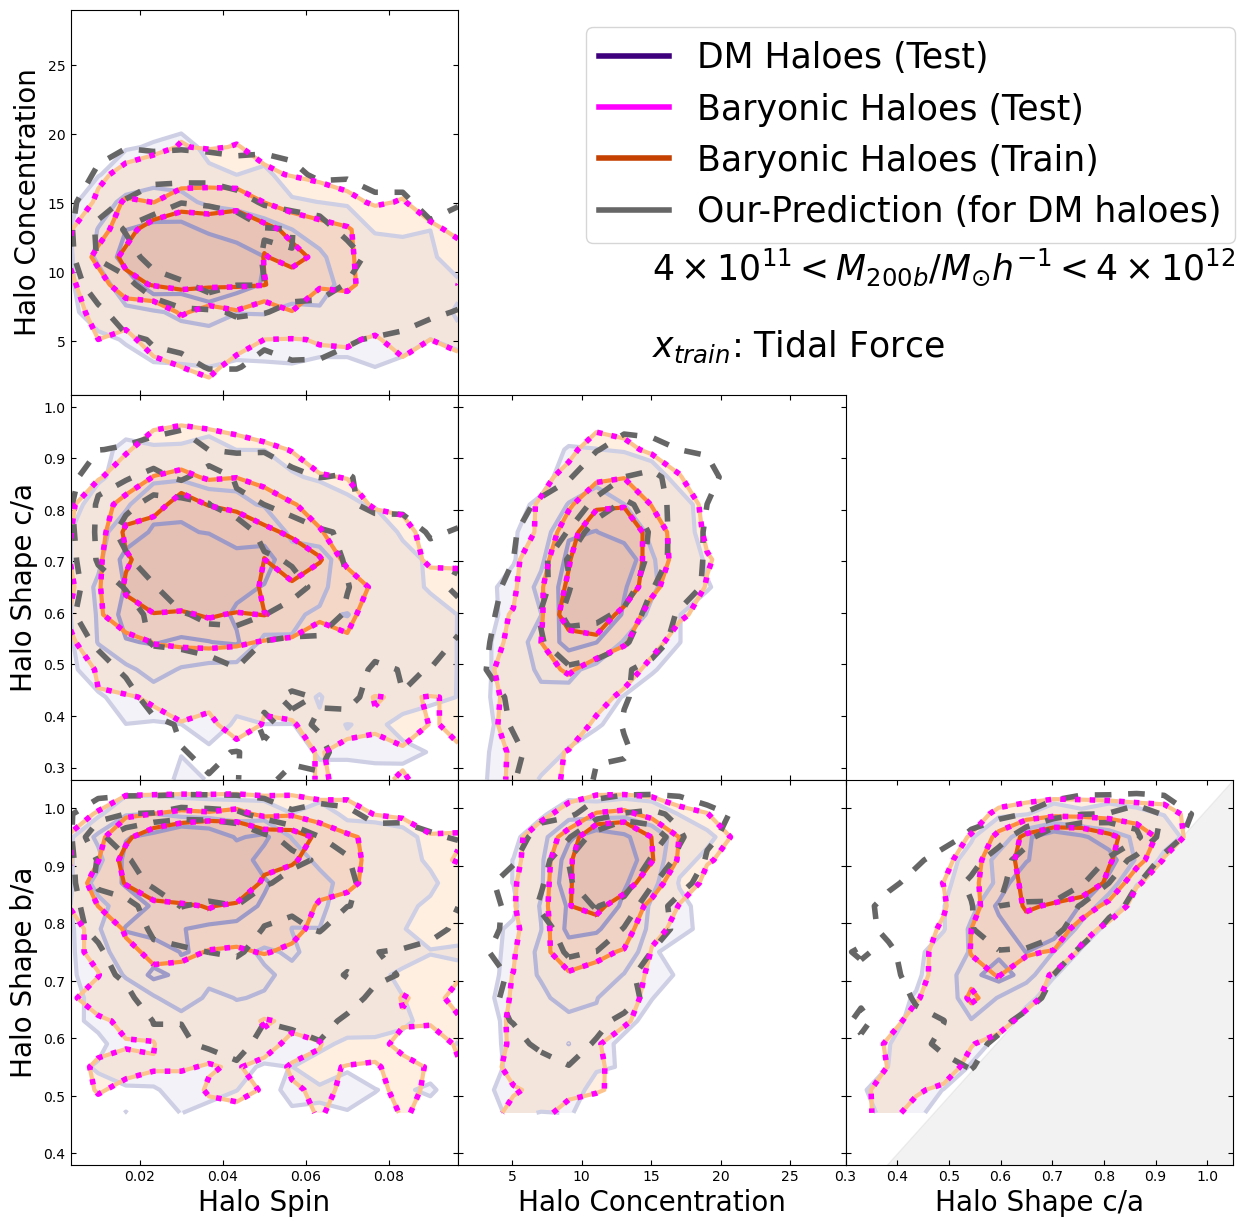

In [40]:
train_dataset_bar = Astrid_data_bar
train_dataset_dm  = Astrid_data_dm

train_dataset_bar = Astrid_data_bar
train_dataset_dm  = Astrid_data_dm

nbins = 3
bins = np.arange(nbins)
for i in bins:
    print(i,'Mass range:',"%.4g"% 10**bins_M_bar[i],"%.4g"% 10**bins_M_bar[i+1])


    halos_bar = train_dataset_bar[(np.log10(train_dataset_bar.M200b) >= bins_M_bar[i]) & (np.log10(train_dataset_bar.M200b) < bins_M_bar[i+1]) & (train_dataset_bar.pid == -1)
                              & (train_dataset_bar.T_U < 1000)]
    halos_dm = train_dataset_dm[(np.log10(train_dataset_dm.M200b02d) >= bins_M_bar[i]) & (np.log10(train_dataset_dm.M200b02d) < bins_M_bar[i+1]) & (train_dataset_dm.pid == -1)
                            & (train_dataset_dm.T_U < 1000)]



    halos_bar_test = Astrid_data_bar[(np.log10(Astrid_data_bar.M200b) >= bins_M_bar[i]) & (np.log10(Astrid_data_bar.M200b) < bins_M_bar[i+1]) & (Astrid_data_bar.pid == -1)
                                    & (Astrid_data_bar.T_U < 1000)]
    halos_dm_test = train_dataset_dm[(np.log10(train_dataset_dm.M200b02d) >= bins_M_bar[i]) & (np.log10(train_dataset_dm.M200b02d) < bins_M_bar[i+1]) & (train_dataset_dm.pid == -1)
                              & (train_dataset_dm.T_U < 1000)]

    print('# halos bar:',len(halos_bar),'# halos dm:',len(halos_dm))
    
    cg = ConditionalMultiVariateGaussian()
    x_train = np.asarray(halos_bar[['TidalForce']]) #np.random.randn(100000,2) ## this could be 100000 baryonified haloes with 2 input properties
    y_train = np.asarray(halos_bar[['cv','Spin','ca','ba']]) #np.random.randn(100000,3) ## this could be 100000 baryonified haloes with 3 output properties
    #x_test  = np.asarray(halos_dm_test[['TidalForce']]) #np.random.randn(20000,2)   ## this could be 20000 dm haloes with 2 input properties
    x_test = np.random.uniform(np.min(halos_dm_test[['TidalForce']]), np.max(halos_dm_test[['TidalForce']]), len(halos_dm_test[['TidalForce']])).reshape(len(halos_dm_test[['TidalForce']]),1)

    print (x_train.shape)
    print (y_train.shape)
    cg.fit(x_train,y_train)
    y_pred = cg.predict(x_test)
    print(y_pred.shape)
    valy1,edge1,edge2 = np.histogram2d(halos_dm.cv, halos_dm.ba, bins=30, density = False)
    edgex = am(edge1)
    edgey = am(edge2)
    pylab.figure(num = None, figsize = (8, 6), dpi=80, facecolor = 'w', edgecolor = 'k')

    plt.plot(halos_bar.cv, halos_bar.ba,'.',label = "Astrid CV")
    plt.plot(halos_dm.cv, halos_dm.ba,'.',label = "Astrid CV")

    lvl = confidence_intervals(valy1.T/valy1.sum())
    plt.contour(edgex, edgey,valy1.T/valy1.sum(),levels=lvl,cmap='Reds')
    plt.colorbar()

    plt.title('Astrid & Astrid_DM', fontsize = 13)
    plt.legend(loc = 0, borderaxespad = 1.)
    plt.xlabel('c', fontsize=13)
    plt.ylabel(r'$b/a$', fontsize=13)
    pylab.figure(num = None, figsize = (8, 6), dpi=80, facecolor = 'w', edgecolor = 'k')

    plt.plot(halos_bar.cv, halos_bar.Rvir,'.',label = "Astrid CV")
    plt.plot(halos_dm.cv, halos_dm.Rvir,'.',label = "Astrid_DM CV")

    plt.title('Astrid & Astrid_DM', fontsize = 13)
    plt.legend(loc = 0, borderaxespad = 1.)
    plt.xlabel('c', fontsize=13)
    plt.ylabel(r'$R_{vir}$', fontsize=13)
    bins = 15
    
    ##spin vs conc
    ca_range   = [0.25, 1.05]
    conc_range = [0.1, 30]
    ba_range   = [0.45, 1.05]
    spin_range = [0, 0.1]
    rvir_range = [120, 200]
    density    = False
    valy1,edge1,edge2 = np.histogram2d(halos_bar.Spin, halos_bar.cv, bins=bins, range = [ spin_range,conc_range],density=density)
    valx1,edge1,edge2 = np.histogram2d(halos_dm_test.Spin, halos_dm_test.cv, bins=bins, range = [ spin_range,conc_range],density=density)
    valp1,edge1,edge2 = np.histogram2d(y_pred[:,1], y_pred[:,0], bins=bins, range = [ spin_range,conc_range],density=density)
    valp2,edge1,edge2 = np.histogram2d(halos_bar_test.Spin, halos_bar_test.cv, bins=bins, range = [ spin_range,conc_range],density=density)
    edgex = am(edge1)
    edgey = am(edge2)

    ## vs c/a
    _2valy1,edge1,edge2 = np.histogram2d(halos_bar.Spin, halos_bar.ca, bins=bins, range = [ spin_range,ca_range],density=density)
    _2valx1,edge1,edge2 = np.histogram2d(halos_dm_test.Spin, halos_dm_test.ca, bins=bins, range = [ spin_range,ca_range],density=density)
    _2valp1,edge1,edge2 = np.histogram2d(y_pred[:,1], y_pred[:,2], bins=bins, range = [ spin_range,ca_range],density=density)
    _2valp2,edge1,edge2 = np.histogram2d(halos_bar_test.Spin, halos_bar_test.ca, bins=bins, range = [ spin_range,ca_range],density=density)
    _2edgex = am(edge1)
    _2edgey = am(edge2)
    #%


    _3valy1,edge1,edge2 = np.histogram2d(halos_bar.Spin, halos_bar.ba, bins=bins, range = [ spin_range,ba_range],density=density)
    _3valx1,edge1,edge2 = np.histogram2d(halos_dm_test.Spin, halos_dm_test.ba, bins=bins, range = [ spin_range,ba_range],density=density)
    _3valp1,edge1,edge2 = np.histogram2d(y_pred[:,1], y_pred[:,3], bins=bins, range = [ spin_range,ba_range],density=density)
    _3valp2,edge1,edge2 = np.histogram2d(halos_bar_test.Spin, halos_bar_test.ba, bins=bins, range = [ spin_range,ba_range],density=density)
    _3edgex = am(edge1)
    _3edgey = am(edge2)

    ## halo concentration vs c/a
    _4valy1,edge1,edge2 = np.histogram2d(halos_bar.cv, halos_bar.ca, bins=bins, range = [ conc_range,ca_range],density=density)
    _4valx1,edge1,edge2 = np.histogram2d(halos_dm_test.cv, halos_dm_test.ca, bins=bins, range = [ conc_range,ca_range],density=density)
    _4valp1,edge1,edge2 = np.histogram2d(y_pred[:,0], y_pred[:,2], bins=bins, range = [ conc_range,ca_range],density=density)
    _4valp2,edge1,edge2 = np.histogram2d(halos_bar_test.cv, halos_bar_test.ca, bins=bins, range = [ conc_range,ca_range],density=density)
    _4edgex = am(edge1)
    _4edgey = am(edge2)

    ## halo concentration vs b/a
    _5valy1,edge1,edge2 = np.histogram2d(halos_bar.cv, halos_bar.ba, bins=bins, range = [ conc_range,ba_range],density=density)
    _5valx1,edge1,edge2 = np.histogram2d(halos_dm_test.cv, halos_dm_test.ba, bins=bins, range = [ conc_range,ba_range],density=density)
    _5valp1,edge1,edge2 = np.histogram2d(y_pred[:,0], y_pred[:,3], bins=bins, range = [ conc_range,ba_range],density=density)
    _5valp2,edge1,edge2 = np.histogram2d(halos_bar_test.cv, halos_bar_test.ba, bins=bins, range = [ conc_range,ba_range],density=density)
    _5edgex = am(edge1)
    _5edgey = am(edge2)

    ## ca vs b/a
    _6valy1,edge1,edge2 = np.histogram2d(halos_bar.ca, halos_bar.ba, bins=bins, range = [ ca_range,ba_range],density=density)
    _6valx1,edge1,edge2 = np.histogram2d(halos_dm_test.ca, halos_dm_test.ba, bins=bins, range = [ ca_range,ba_range],density=density)
    _6valp1,edge1,edge2 = np.histogram2d(y_pred[:,2], y_pred[:,3], bins=bins, range = [ ca_range,ba_range],density=density)
    _6valp2,edge1,edge2 = np.histogram2d(halos_bar_test.ca, halos_bar_test.ba, bins=bins, range = [ ca_range,ba_range],density=density)

    _6edgex = am(edge1)
    _6edgey = am(edge2)

    cmap = matplotlib.cm.get_cmap('Purples')
    colorp = [cmap(0.3), cmap(0.4),cmap(0.5),cmap(1.0)]
    colorpp = [cmap(0.3), cmap(0.4),cmap(0.5),cmap(0.9)]
    cmap = matplotlib.cm.get_cmap('binary')
    colorb = [ cmap(0.6),cmap(0.6),cmap(0.6),cmap(0.6)]
    cmap = matplotlib.cm.get_cmap('Oranges')
    coloro = [cmap(0.3), cmap(0.5),cmap(0.7),cmap(0.8)]
    coloroo = [cmap(0.3), cmap(0.5),cmap(0.7),cmap(0.89)]

    
    ######################
    t = time.time()

    lvl = [0.0014,0.0028,0.0035,1]
    lvl = 3
    lvl = [0.0014,0.0028,0.01]

    vmax = 0.008
    vmaxcont = 0.005

    fig,axs  = plt.subplots(3,3,figsize=(15,15),gridspec_kw={ 'wspace':0,'hspace': 0},sharex='col',sharey='row')
    axs[0, 2].axis('off')
    axs[0, 1].axis('off')
    axs[1, 2].set_visible(False)

    ax = axs[0,0]
    h1,h2,h3 = easyplot(valx1,valy1,valp1,edgex,edgey)
    axs[0,0].yaxis.set_ticks_position('both')
    axs[0,0].tick_params(axis='x', direction='in')
    axs[0,0].tick_params(axis='y', direction='in')
    axs[0,0].xaxis.set_ticks_position('both')
    axs[0,0].set_ylabel('Halo Concentration',fontsize=20)
    if i ==0:
        axs[0,0].text(1.5,0.3, '$ 10^{10} < M_{200b}/M_{\odot}h^{-1} < 6.3 \\times 10^{10}$', transform = axs[0,0].transAxes, fontsize = 25)
        axs[0,0].text(1.5,0.1, '$x_{train}$: Tidal Force', transform = axs[0,0].transAxes, fontsize = 25)

    if i ==1:
        axs[0,0].text(1.5,0.3, '$6.3 \\times 10^{10} < M_{200b}/M_{\odot}h^{-1} < 4 \\times 10^{11}$', transform = axs[0,0].transAxes, fontsize = 25)
        axs[0,0].text(1.5,0.1, '$x_{train}$: Tidal Force', transform = axs[0,0].transAxes, fontsize = 25)

    if i ==2:
        axs[0,0].text(1.5,0.3, '$4 \\times 10^{11} < M_{200b}/M_{\odot}h^{-1} < 4 \\times 10^{12}$', transform = axs[0,0].transAxes, fontsize = 25)
        axs[0,0].text(1.5,0.1, '$x_{train}$: Tidal Force', transform = axs[0,0].transAxes, fontsize = 25)

    if i ==3:
        axs[0,0].text(1.5,0.3, '$4 \\times 10^{12} < M_{200b}/M_{\odot}h^{-1} < 4 \\times 10^{14}$', transform = axs[0,0].transAxes, fontsize = 25)
        axs[0,0].text(1.5,0.1, '$x_{train}$: Tidal Force', transform = axs[0,0].transAxes, fontsize = 25)
          
    if h3 is not None:
        #axs[0,0].legend([h1[-2], h2[-2],h3[-2]], ['DM Haloes (Test)', 'Baryonic Haloes (Test)', 'Baryonic Haloes (Train)','Our-Prediction (for DM haloes)'],fontsize=25,bbox_to_anchor=(3.05, 1))
        axs[0,0].legend([line0,line1,line2,line3], ['DM Haloes (Test)', 'Baryonic Haloes (Test)', 'Baryonic Haloes (Train)','Our-Prediction (for DM haloes)'],fontsize=25,bbox_to_anchor=(3.05, 1))
    else:
        axs[0,0].legend([h1[-2], h2[-2]], ['DM Haloes', 'Baryonic Haloes'],fontsize=25,bbox_to_anchor=(3.05, 1))
        axs[0,0].text(2,0.5, '$2 \\times 10^{11} < M_{200}/M_{\odot}h^{-1} < 10^{12}$', transform = axs[0,0].transAxes, fontsize = 25)
    
    lvl = confidence_intervals(valp2.T/valp2.sum())
    axs[0,0].contour(edgex,edgey,valp2.T/valp2.sum(),levels=lvl,colors='magenta',linewidths=4,linestyles=':')
    #h3,l3 = CS.legend_elements()
    #for c in CS.collections:
    #    c.set_dashes([(1,(3.0,3.0))])
        
    axs[1,0].set_ylabel('Halo Shape c/a',fontsize=20)
    ax = axs[1,0]
    easyplot(_2valx1,_2valy1,_2valp1,_2edgex,_2edgey)
    lvl = confidence_intervals(_2valp2.T/_2valp2.sum())
    axs[1,0].contour(_2edgex,_2edgey,_2valp2.T/_2valp2.sum(),levels=lvl,colors='magenta',linewidths=4,linestyles=':')
    axs[1,0].yaxis.set_ticks_position('both')
    axs[1,0].tick_params(axis='x', direction='in')
    axs[1,0].tick_params(axis='y', direction='in')
    axs[1,0].xaxis.set_ticks_position('both')
    
    ax = axs[2,0]
    easyplot(_3valx1,_3valy1,_3valp1,_3edgex,_3edgey)
    lvl = confidence_intervals(_3valp2.T/_3valp2.sum())
    axs[2,0].contour(_3edgex,_3edgey,_3valp2.T/_3valp2.sum(),levels=lvl,colors='magenta',linewidths=4,linestyles=':')    
    axs[2,0].set_ylabel('Halo Shape b/a',fontsize=20)
    axs[2,0].yaxis.set_ticks_position('both')
    axs[2,0].tick_params(axis='x', direction='in')
    axs[2,0].tick_params(axis='y', direction='in')
    axs[2,0].xaxis.set_ticks_position('both')
    axs[2,0].set_xlabel('Halo Spin',fontsize=20)


    ## halo conc vs c/a
    ax = axs[1,1]
    easyplot(_4valx1,_4valy1,_4valp1,_4edgex,_4edgey)
    lvl = confidence_intervals(_4valp2.T/_4valp2.sum())
    axs[1,1].contour(_4edgex,_4edgey,_4valp2.T/_4valp2.sum(),levels=lvl,colors='magenta',linewidths=4,linestyles=':')
    axs[1,1].yaxis.set_ticks_position('both')
    axs[1,1].tick_params(axis='x', direction='in')
    axs[1,1].tick_params(axis='y', direction='in')
    axs[1,1].xaxis.set_ticks_position('both')


    ## halo conc vs b/a
    axs[2,1].yaxis.set_ticks_position('both')
    axs[2,1].tick_params(axis='x', direction='in')
    axs[2,1].tick_params(axis='y', direction='in')
    axs[2,1].xaxis.set_ticks_position('both')
    axs[2, 1].set_xlabel('Halo Concentration',fontsize=20)
    ax = axs[2,1]
    easyplot(_5valx1,_5valy1,_5valp1,_5edgex,_5edgey)
    lvl = confidence_intervals(_5valp2.T/_5valp2.sum())
    axs[2,1].contour(_5edgex,_5edgey,_5valp2.T/_5valp2.sum(),levels=lvl,colors='magenta',linewidths=4,linestyles=':')


    ## halo conc vs b/a
    axs[2,2].yaxis.set_ticks_position('both')
    axs[2,2].tick_params(axis='x', direction='in')
    axs[2,2].tick_params(axis='y', direction='in')
    axs[2,2].xaxis.set_ticks_position('both')
    ax = axs[2,2]
    x = np.linspace(0, 1.1, 4)
    y = x
    plt.fill_between(x, y, where=(x > 0), color='grey', alpha=0.1)
    ax.set_xlim([0.3,1.05])
    ax.set_ylim([0.38,1.05])

    easyplot(_6valx1,_6valy1,_6valp1,_6edgex,_6edgey)
    lvl = confidence_intervals(_6valp2.T/_6valp2.sum())
    axs[2,2].contour(_6edgex,_6edgey,_6valp2.T/_6valp2.sum(),levels=lvl,colors='magenta',linewidths=4,linestyles=':')


    axs[2, 2].set_xlabel('Halo Shape c/a',fontsize=20)

    plt.savefig('graph/Astrid_Random_BarVsDM'+str(i)+'_AllHalos.pdf')
    
    
    #check dm halo concentrations
    #meanHdms = stats.binned_statistic(np.log10(halos_dm.M200b02d),np.log10(halos_dm.M200b02d),statistic='mean', bins=11, range=(halos_bar.M200b.min(),halos_bar.M200b.max()))
    #meanHdm = 10**meanHdms[0]
    #cvmdms = stats.binned_statistic(np.log10(halos_dm.M200b02d),np.log10(halos_dm.cv),statistic='median', bins=11,range=(halos_bar.M200b.min(),halos_bar.M200b.max()))
    #cvm_dm_sim = 10**cvmdms[0]
    #%cvmdms_pred = stats.binned_statistic(np.log10(halos_dm.M200b02d),np.log10(y_pred[:,0]),statistic='median', bins=11,range=(halos_bar.M200b.min(),halos_bar.M200b.max()))
    #%cvm_dm_pred = 10**cvmdms_pred[0]
    #pylab.figure(num = None, figsize = (8, 6), dpi=80, facecolor = 'w', edgecolor = 'k')
    #plt.plot(meanHdm, cvm_dm_sim,'-',label = "simulations")
    #plt.plot(meanHdm, cvm_dm_pred,'-',label = "our-prediction")

0 Mass range: 1e+10 6.31e+10
# halos bar: 66562 # halos dm: 71881
(66562, 1)
(66562, 4)
here
acceptance rate is  89.4186871011482 %
pval (Bar-DM) = 1.5563854405766362e-60
pval (Bar-pred) = 0.026546811931941597
pval (Bar-DM) = 0.061314567263710956
pval (Bar-pred) = 0.49623226435327117
pval (Bar-DM) = 0.0
pval (Bar-pred) = 0.0028517312552505617
pval (Bar-DM) = 3.48897863392301e-265
pval (Bar-pred) = 1.085173979776323e-11


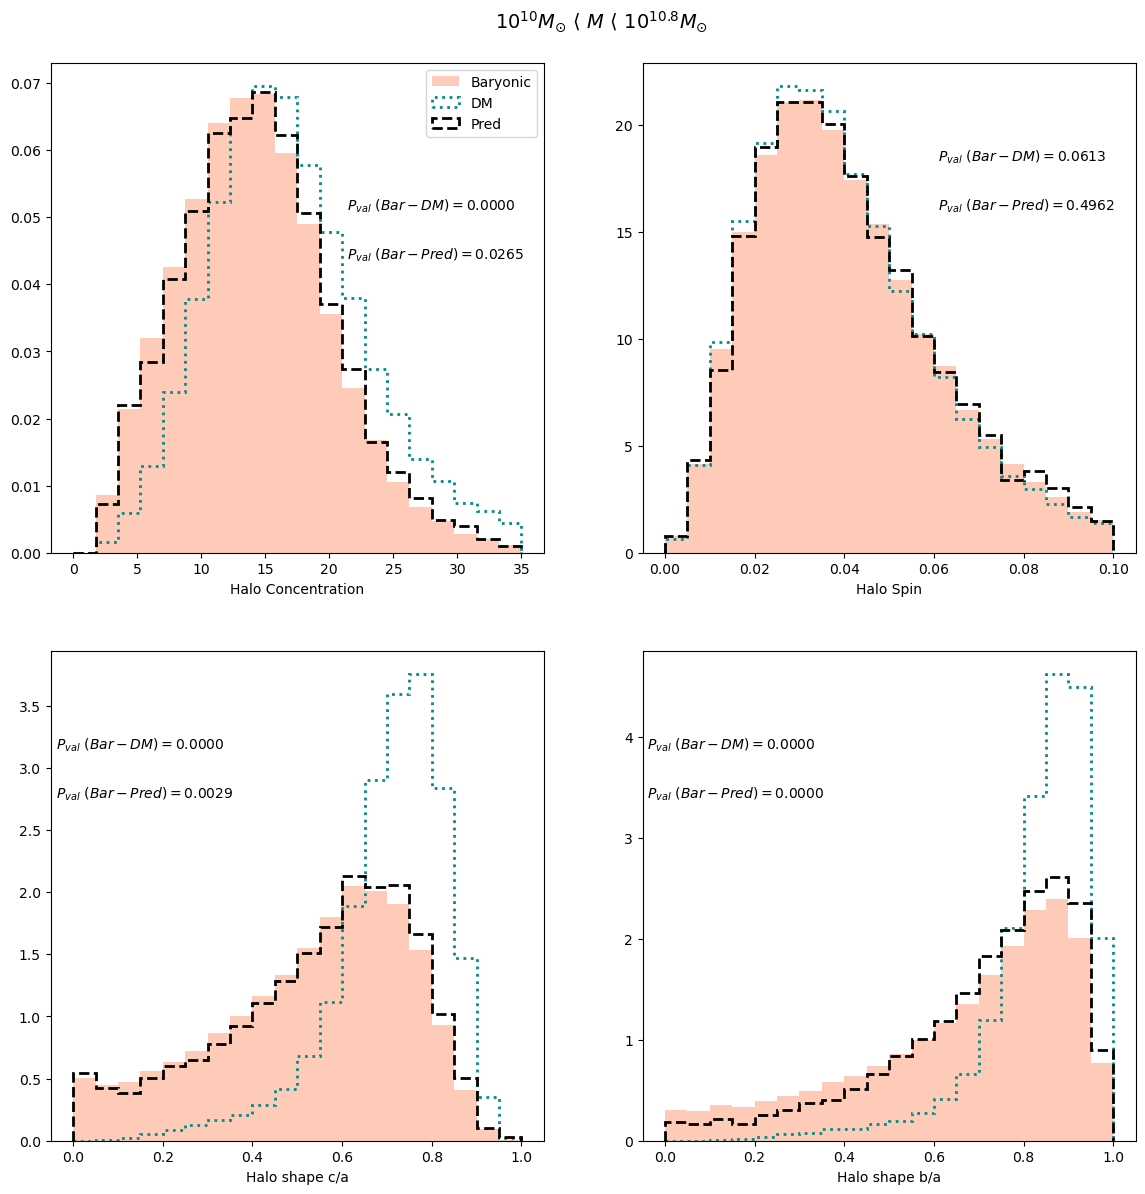

1 Mass range: 6.31e+10 3.981e+11
# halos bar: 15822 # halos dm: 14864
(15822, 1)
(15822, 4)
here
acceptance rate is  91.52145803829814 %
pval (Bar-DM) = 1.4993953686264963e-55
pval (Bar-pred) = 0.003797792787144442
pval (Bar-DM) = 2.513986969863627e-12
pval (Bar-pred) = 0.002465208749609002
pval (Bar-DM) = 2.1655189441787885e-119
pval (Bar-pred) = 0.1018980612381279
pval (Bar-DM) = 3.687463653744609e-48
pval (Bar-pred) = 1.7922368319336188e-10


<Figure size 640x480 with 0 Axes>

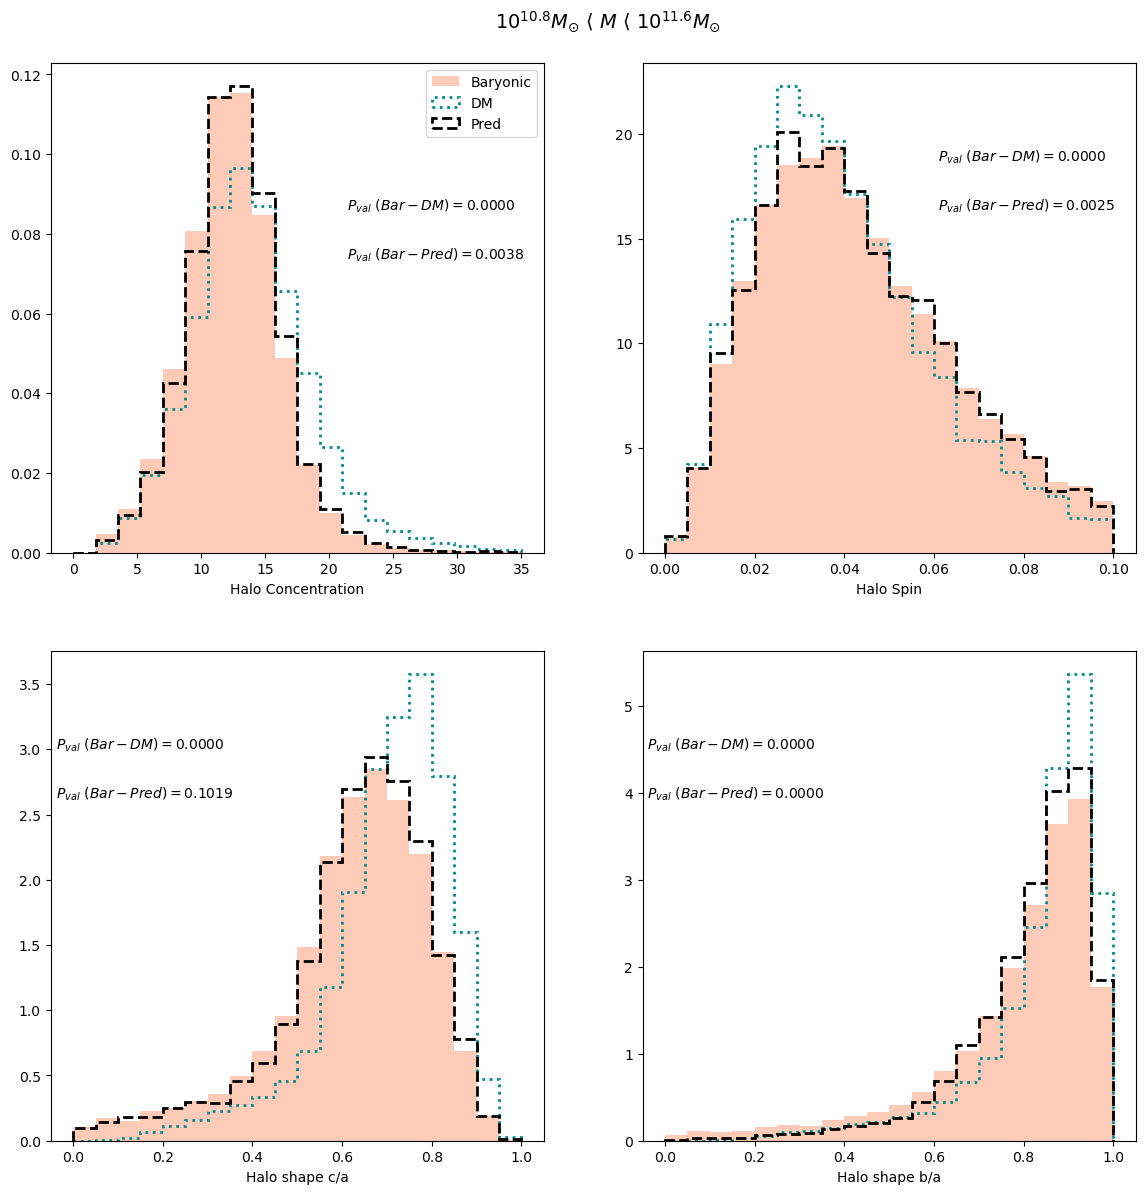

2 Mass range: 3.981e+11 3.981e+12
# halos bar: 3647 # halos dm: 3234
(3647, 1)
(3647, 4)
here
acceptance rate is  91.48514851485149 %
pval (Bar-DM) = 9.710340560622662e-13
pval (Bar-pred) = 0.008146286950433918
pval (Bar-DM) = 2.210666790366506e-12
pval (Bar-pred) = 0.6882133153522553
pval (Bar-DM) = 3.1946767485522377e-11
pval (Bar-pred) = 0.004878252802269427
pval (Bar-DM) = 4.8480075228106625e-25
pval (Bar-pred) = 1.467347137328297e-11


<Figure size 640x480 with 0 Axes>

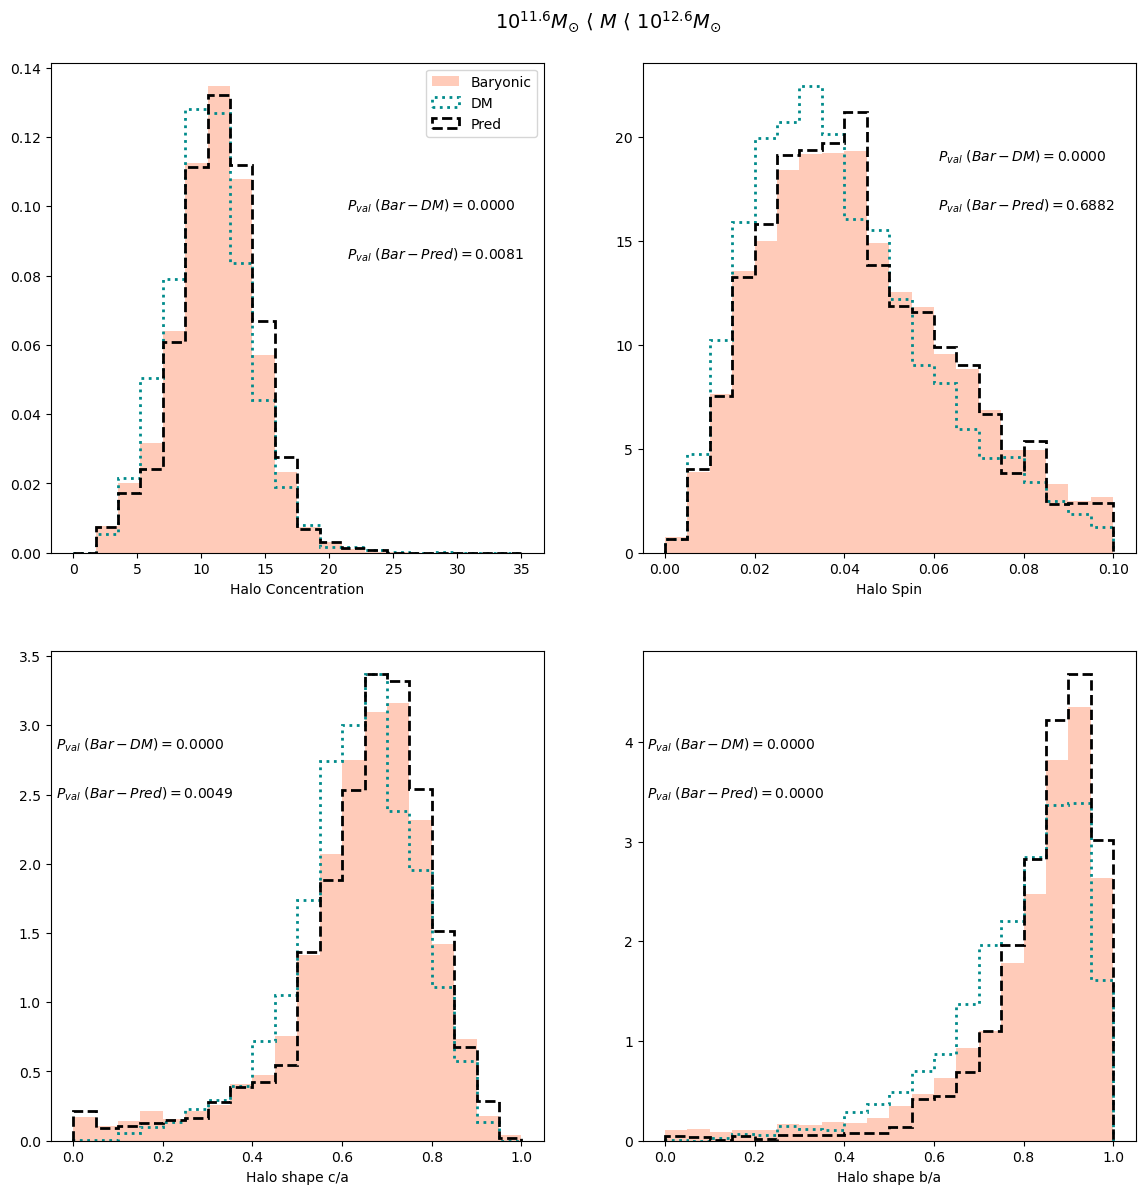

<Figure size 640x480 with 0 Axes>

In [41]:
font1 = {'color':  'red',
        'weight': 'normal',
        'size': 13,
        }
font2 = {'color':  'darkmagenta',
        'weight': 'normal',
        'size': 13,
        }
font3 = {'color':  'darkgreen',
        'weight': 'normal',
        'size': 13,
        }
font4 = {'color':  'black',
        'weight': 'normal',
        'size': 12.5,
        }
nbins = 3
bins = np.arange(nbins)

hist_bins = 20
titles = ['$10^{10} M_{\odot} \ \langle \ M \ \langle \ 10^{10.8} M_{\odot}$',
          '$10^{10.8} M_{\odot} \ \langle \ M \ \langle \ 10^{11.6} M_{\odot}$',
          '$10^{11.6} M_{\odot} \ \langle \ M \ \langle \ 10^{12.6} M_{\odot}$']
for i in bins:
    print(i,'Mass range:',"%.4g"% 10**bins_M_bar[i],"%.4g"% 10**bins_M_bar[i+1])

    halos_bar = train_dataset_bar[(np.log10(train_dataset_bar.M200b) >= bins_M_bar[i]) & (np.log10(train_dataset_bar.M200b) < bins_M_bar[i+1]) & (train_dataset_bar.pid == -1)
                              & (train_dataset_bar.T_U < 1)]
    halos_dm = train_dataset_dm[(np.log10(train_dataset_dm.M200b02d) >= bins_M_bar[i]) & (np.log10(train_dataset_dm.M200b02d) < bins_M_bar[i+1]) & (train_dataset_dm.pid == -1)
                            & (train_dataset_dm.T_U < 1)]



    halos_bar_test = Astrid_data_bar[(np.log10(Astrid_data_bar.M200b) >= bins_M_bar[i]) & (np.log10(Astrid_data_bar.M200b) < bins_M_bar[i+1]) & (Astrid_data_bar.pid == -1)
                                    & (Astrid_data_bar.T_U < 1)]
    halos_dm_test = train_dataset_dm[(np.log10(train_dataset_dm.M200b02d) >= bins_M_bar[i]) & (np.log10(train_dataset_dm.M200b02d) < bins_M_bar[i+1]) & (train_dataset_dm.pid == -1)
                              & (train_dataset_dm.T_U < 1)]
    
    print('# halos bar:',len(halos_bar),'# halos dm:',len(halos_dm))
    
        
    cg = ConditionalMultiVariateGaussian()
    x_train = np.asarray(halos_bar[['TidalForce']]) #np.random.randn(100000,2) ## this could be 100000 baryonified haloes with 2 input properties
    y_train = np.asarray(halos_bar[['cv','Spin','ca','ba']]) #np.random.randn(100000,3) ## this could be 100000 baryonified haloes with 3 output properties
    #x_test  = np.asarray(halos_dm_test[['TidalForce']]) #np.random.randn(20000,2)   ## this could be 20000 dm haloes with 2 input properties
    x_test = np.random.uniform(np.min(halos_dm_test[['TidalForce']]), np.max(halos_dm_test[['TidalForce']]), len(halos_dm_test[['TidalForce']])).reshape(len(halos_dm_test[['TidalForce']]),1)

    print (x_train.shape)
    print (y_train.shape)
    cg.fit(x_train,y_train)
    y_pred = cg.predict(x_test)
    
    fig, ax = plt.subplots(2,2, figsize = (14,14))
    
    # CV
    ax[0,0].hist(halos_bar.cv, color = 'coral', lw = 2, bins = hist_bins, range = (0,35), alpha = 0.4, label = 'Baryonic', density = True)
    ax[0,0].hist(halos_dm.cv, histtype = 'step', color = 'darkcyan', lw = 2, bins = hist_bins, range = (0,35), ls = ':', label = 'DM', density = True)
    ax[0,0].hist(y_pred[:,0], histtype = 'step', color = 'black', lw = 2, bins = hist_bins, range = (0,35), ls = '--', label = 'Pred', density = True)

    if len(halos_bar) > 5000: 
        ind_bar = np.random.choice(len(halos_bar), 5000, replace = False)
    else: ind_bar = np.arange(len(halos_bar))
    if len(halos_dm) > 5000: ind_dm = np.random.choice(len(halos_dm), 5000, replace = False)
    else: ind_dm = np.arange(len(halos_dm))
    
    ks = ks_2samp(halos_bar.iloc[ind_bar].cv, halos_dm.iloc[ind_dm].cv)[1]
    print('pval (Bar-DM) = ' + str(ks))
    ax[0,0].text(0.6,0.7, '$P_{val}\ (Bar-DM)=$' + '{:.4f}'.format(ks), transform = ax[0,0].transAxes)
    ks = ks_2samp(halos_bar.iloc[ind_bar].cv, y_pred[ind_dm,0])[1]
    print('pval (Bar-pred) = ' + str(ks))
    ax[0,0].text(0.6,0.6, '$P_{val}\ (Bar-Pred)=$' + '{:.4f}'.format(ks), transform = ax[0,0].transAxes)

    ax[0,0].set_xlabel('Halo Concentration')
    ax[0,0].legend()
    ax[0,0].text(0.9,1.07, titles[i], transform = ax[0,0].transAxes, fontsize = 14)
    
    # Spin
    ax[0,1].hist(halos_bar.Spin, color = 'coral', lw = 2, bins = hist_bins, range = (0,0.1), alpha = 0.4, label = 'Baryonic', density = True)
    ax[0,1].hist(halos_dm.Spin, histtype = 'step', color = 'darkcyan', lw = 2, bins = hist_bins, range = (0,0.1), ls = ':', label = 'DM', density = True)
    ax[0,1].hist(y_pred[:,1], histtype = 'step', color = 'black', lw = 2, bins = hist_bins, range = (0,0.1), ls = '--', label = 'Pred', density = True)

    ks = ks_2samp(halos_bar.iloc[ind_bar].Spin, halos_dm.iloc[ind_dm].Spin)[1]
    print('pval (Bar-DM) = ' + str(ks))
    ax[0,1].text(0.6,0.8, '$P_{val}\ (Bar-DM)=$' + '{:.4f}'.format(ks), transform = ax[0,1].transAxes)
    ks = ks_2samp(halos_bar.iloc[ind_bar].Spin, y_pred[ind_dm,1])[1]
    print('pval (Bar-pred) = ' + str(ks))
    ax[0,1].text(0.6,0.7, '$P_{val}\ (Bar-Pred)=$' + '{:.4f}'.format(ks), transform = ax[0,1].transAxes)

    ax[0,1].set_xlabel('Halo Spin')
    
    # Ca
    ax[1,0].hist(halos_bar.ca, color = 'coral', lw = 2, bins = hist_bins, range = (0,1), alpha = 0.4, label = 'Baryonic', density = True)
    ax[1,0].hist(halos_dm.ca, histtype = 'step', color = 'darkcyan', lw = 2, bins = hist_bins, range = (0,1), ls = ':', label = 'DM', density = True)
    ax[1,0].hist(y_pred[:,2], histtype = 'step', color = 'black', lw = 2, bins = hist_bins, range = (0,1), ls = '--', label = 'Pred', density = True)

    ks = ks_2samp(halos_bar.iloc[ind_bar].ca, halos_dm.iloc[ind_dm].ca)[1]
    print('pval (Bar-DM) = ' + str(ks))
    ax[1,0].text(0.01,0.8, '$P_{val}\ (Bar-DM)=$' + '{:.4f}'.format(ks), transform = ax[1,0].transAxes)
    ks = ks_2samp(halos_bar.iloc[ind_bar].ca, y_pred[ind_dm,2])[1]
    print('pval (Bar-pred) = ' + str(ks))
    ax[1,0].text(0.01,0.7, '$P_{val}\ (Bar-Pred)=$' + '{:.4f}'.format(ks), transform = ax[1,0].transAxes)

    ax[1,0].set_xlabel('Halo shape c/a')
    
    # CV
    ax[1,1].hist(halos_bar.ba, color = 'coral', lw = 2, bins = hist_bins, range = (0,1), alpha = 0.4, label = 'Baryonic', density = True)
    ax[1,1].hist(halos_dm.ba, histtype = 'step', color = 'darkcyan', lw = 2, bins = hist_bins, range = (0,1), ls = ':', label = 'DM', density = True)
    ax[1,1].hist(y_pred[:,3], histtype = 'step', color = 'black', lw = 2, bins = hist_bins, range = (0,1), ls = '--', label = 'Pred', density = True)

    ks = ks_2samp(halos_bar.iloc[ind_bar].ba, halos_dm.iloc[ind_dm].ba)[1]
    print('pval (Bar-DM) = ' + str(ks))
    ax[1,1].text(0.01,0.8, '$P_{val}\ (Bar-DM)=$' + '{:.4f}'.format(ks), transform = ax[1,1].transAxes)
    ks = ks_2samp(halos_bar.iloc[ind_bar].ba, y_pred[ind_dm,3])[1]
    print('pval (Bar-pred) = ' + str(ks))
    ax[1,1].text(0.01,0.7, '$P_{val}\ (Bar-Pred)=$' + '{:.4f}'.format(ks), transform = ax[1,1].transAxes)

    ax[1,1].set_xlabel('Halo shape b/a')
    
    plt.savefig('graph/Astrid_Random_1d_distributions_' + str(i) + '_AllHalos.pdf')
    plt.show()
    plt.clf()